# Barcelona

Detection of Spatial Signatures in FUA of Barcelona.

1. [x] data retrieval
    - [x] footprints (cadastre)
    - [x] street network (open data portal https://opendata-ajuntament.barcelona.cat/data/en/)
    - [x] functional layers (open data portal)
    - [x] barriers (OSM)
2. [x] data pre-processing
    - [x] footprints checks
    - [x] barries checks
3. [x] generate geographies
    - [x] enclosures
    - [x] enclosed tessellation
4. [x] morphometrics
    - [x] primary characters
    - [x] convolutions
5. [ ] functional layers
6. [ ] cluster analysis

In [1]:
import requests
import geopandas as gpd
from download import download
import osmnx as ox
import momepy
import libpysal
import numpy as np
import warnings
import pandas as pd
import tobler
import pandana

import utils.momepy
import utils.tobler

In [2]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

In [14]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/6fd03b36-7503-42f0-9082-9040cb812423/resource/a11a534d-4aeb-497f-b6bd-2e170b4724aa/download"
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/streets"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.84M/1.84M [00:01<00:00, 1.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/streets


'../../urbangrammar_samba/sp_sig_concept/barcelona/streets'

In [16]:
response = requests.get('http://www.catastro.minhap.es/INSPIRE/buildings/08/ES.SDGC.bu.atom_08.xml')
links = []

for link in response.text.split('<link rel="enclosure" href="')[1:]:
    links.append(link.split('"')[0].strip())

In [18]:
bcn = [l for l in links if 'BARCELONA' in l]

In [19]:
bcn

['http://www.catastro.minhap.es/INSPIRE/Buildings/08/08900-BARCELONA/A.ES.SDGC.BU.08900.zip']

In [20]:
data = bcn[0]
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/buildings"
download(data, path, kind='zip')

Creating data folder...

file_sizes: 100%|██████████████████████████| 44.4M/44.4M [00:11<00:00, 3.70MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/buildings


'../../urbangrammar_samba/sp_sig_concept/barcelona/buildings'

In [22]:
buildings = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings/A.ES.SDGC.BU.08900.building.gml")

In [23]:
roads = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")

## OSM barriers

Identification of enclosures should optimally contain variety of barriers, not only street networks. Therefore we download railway and water geometry from OSM. 

The required version of `OSMnx` for this section is 0.16+ which includes `geometries` module.

In [50]:
bounds = roads.to_crs(4326).total_bounds
bounds

array([ 2.05905748, 41.32133238,  2.22232372, 41.46827616])

In [55]:
tags = {'natural': ['water', 'coastline', 'spring']}

water = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
water = water.to_crs(roads.crs)
water[['natural', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/water.pq")

<ipython-input-55-9939be0dd3ac>:5: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  water[['natural', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/water.pq")


In [64]:
tags = {'railway': True}

railway = ox.geometries_from_bbox(bounds[3], bounds[1], bounds[2], bounds[0], tags)
railway = railway.to_crs(roads.crs)
railway = railway[railway.geom_type == 'LineString']
railway = railway[railway.tunnel != 'yes']
railway = railway[~railway.railway.isin(['miniature', 'tram'])]
railway[['railway', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")

<ipython-input-64-1424e3d9b068>:8: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  railway[['railway', 'geometry']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")


In [67]:
data = "https://opendata-ajuntament.barcelona.cat/data/dataset/808daafa-d9ce-48c0-925a-fa5afdb1ed41/resource/cd800462-f326-429f-a67a-c69b7fc4c50a/download"
path = "../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units"
download(data, path, kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 2.82M/2.82M [00:02<00:00, 1.15MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units


'../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units'

In [68]:
admin = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

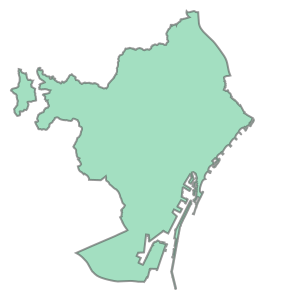

In [70]:
admin.loc[0, 'geometry']

## Data preprocessing

Building checks

In [93]:
buildings = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings/A.ES.SDGC.BU.08900.building.gml")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [94]:
buildings = buildings.explode()

In [95]:
check = momepy.CheckTessellationInput(buildings)

/opt/conda/lib/python3.8/site-packages/momepy/utils.py:1003: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  shrink = shrink[~(shrink.is_empty | shrink.geometry.isna())]


Collapsed features  : 86
Split features      : 339
Overlapping features: 0


In [98]:
check.collapse.area.max()

22.907883144854168

In [99]:
buildings = buildings.drop(check.collapse.index)

In [100]:
buildings.shape

(81440, 25)

In [101]:
buildings["uID"] = range(len(buildings))

In [102]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")

<ipython-input-102-e980985fe82b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")


Barrier checks

In [104]:
roads.geom_type.unique()

array(['LineString'], dtype=object)

In [109]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [116]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

## Generate geography

### Enclosures

In [2]:
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")
roads = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")
railway = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/barrriers/railway.pq")
admin = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

In [3]:
extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

In [4]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=admin.iloc[[0]], additional_barriers=[extended_railway])

CPU times: user 1.4 s, sys: 8.11 ms, total: 1.41 s
Wall time: 1.41 s


In [7]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures)

CPU times: user 48min 53s, sys: 4min 6s, total: 53min
Wall time: 19min 19s


In [9]:
tess.tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")

<ipython-input-9-eb36e9e63444>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")


In [10]:
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")

<ipython-input-10-a76e72ca4c78>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")


## Primary morphometric characters

In [2]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tessellation.pq")
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")
blg = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")
streets = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/streets/BCN_GrafVial_Trams_ETRS89_SHP.shp")

In [3]:
tess = tess.rename_geometry("tessellation").merge(blg[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [4]:
tess['tID'] = range(len(tess))

In [5]:
tess

uID                                       tessellation   eID  \
0      32004.0  POLYGON ((432134.537 4581026.154, 432114.514 4...     0   
1      32005.0  POLYGON ((432143.300 4581011.416, 432142.423 4...     0   
2      32006.0  POLYGON ((432119.125 4581004.320, 432141.346 4...     0   
3      32007.0  POLYGON ((432148.249 4581003.971, 432148.271 4...     0   
4      32008.0  POLYGON ((432148.624 4580987.010, 432147.673 4...     0   
...        ...                                                ...   ...   
82370  56448.0  POLYGON ((427288.332 4577151.951, 427302.223 4...  5852   
82371      NaN  POLYGON ((427407.654 4577101.819, 427405.996 4...  5853   
82372      NaN  POLYGON ((427194.177 4576961.126, 427213.001 4...  5854   
82373      NaN  POLYGON ((427480.333 4577076.215, 427501.055 4...  5855   
82374      NaN  POLYGON ((426836.909 4583807.381, 426836.623 4...  5857   

                                               buildings    tID  
0      POLYGON ((432150.502 4581030.798, 432148.781 4...      0  
1      POLYGON ((432141.079 4581028.136, 432143.721 4...      1  
2      POLYGON ((432148.111 4581012.778, 432148.341 4...      2  
3      POLYGON ((432159.642 4581004.302, 432160.339 4...      3  
4      POLYGON ((432155.041 4580997.493, 432155.961 4...      4  
...                                                  ...    ...  
82370  POLYGON ((427233.783 4576977.073, 427229.417 4...  82370  
82371                                               None  82371  
82372                                               None  82372  
82373                                               None  82373  
82374                                               None  82374  

[82375 rows x 5 columns]

In [6]:
blg = tess.set_geometry('buildings').dropna()

In [7]:
%time blg['sdbAre'] = momepy.Area(blg).series
%time blg['sdbPer'] = momepy.Perimeter(blg).series
%time blg['sdbCoA'] = momepy.CourtyardArea(blg, 'sdbAre').series

%time blg['ssbCCo'] = momepy.CircularCompactness(blg, 'sdbAre').series
%time blg['ssbCor'] = momepy.Corners(blg).series
%time blg['ssbSqu'] = momepy.Squareness(blg).series
%time blg['ssbERI'] = momepy.EquivalentRectangularIndex(blg, 'sdbAre', 'sdbPer').series
%time blg['ssbElo'] = momepy.Elongation(blg).series

CPU times: user 16.2 ms, sys: 106 µs, total: 16.3 ms
Wall time: 15.1 ms
CPU times: user 17.4 ms, sys: 704 µs, total: 18.1 ms
Wall time: 17.6 ms
CPU times: user 113 ms, sys: 22.7 ms, total: 135 ms
Wall time: 132 ms


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:773: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  1%|          | 436/81567 [00:00<00:18, 4358.95it/s]

CPU times: user 4.73 s, sys: 33.5 ms, total: 4.76 s
Wall time: 4.74 s


  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:862: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(cosine_angle))
  0%|          | 248/81567 [00:00<00:32, 2478.35it/s]

CPU times: user 25.4 s, sys: 189 ms, total: 25.5 s
Wall time: 25.4 s


 95%|█████████▌| 77673/81567 [00:43<00:02, 1701.29it/s]/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 81567/81567 [00:47<00:00, 1710.51it/s]


CPU times: user 47.6 s, sys: 593 ms, total: 48.2 s
Wall time: 47.7 s
CPU times: user 32.9 s, sys: 39.1 ms, total: 33 s
Wall time: 33 s
CPU times: user 32.9 s, sys: 7.67 ms, total: 32.9 s
Wall time: 32.9 s


In [8]:
%time cencon = momepy.CentroidCorners(blg)
blg['ssbCCM'] = cencon.mean
blg['ssbCCD'] = cencon.std

%time blg['stbOri'] = momepy.Orientation(blg).series
 
%time tess['stcOri'] = momepy.Orientation(tess).series

  0%|          | 0/81567 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/momepy/shape.py:1080: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle)
  0%|          | 283/81567 [00:00<00:28, 2821.77it/s]

CPU times: user 46.1 s, sys: 116 ms, total: 46.3 s
Wall time: 46.1 s


  0%|          | 195/82375 [00:00<00:42, 1943.83it/s]

CPU times: user 35.7 s, sys: 72.3 ms, total: 35.8 s
Wall time: 35.7 s


100%|██████████| 82375/82375 [01:42<00:00, 800.64it/s] 

CPU times: user 1min 43s, sys: 132 ms, total: 1min 43s
Wall time: 1min 42s


In [9]:
tess = tess.merge(blg[['tID', 'stbOri']], on='tID', how='left')

In [10]:
%time tess['stbCeA'] = (tess['stbOri'] - tess['stcOri']).abs()

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 1.37 ms


In [11]:
%time tess['sdcLAL'] = momepy.LongestAxisLength(tess).series
%time tess['sdcAre'] = momepy.Area(tess).series
%time tess['sscCCo'] = momepy.CircularCompactness(tess, 'sdcAre').series
%time tess['sscERI'] = momepy.EquivalentRectangularIndex(tess, 'sdcAre').series

%time tess['sicCAR'] = tess.buildings.area / tess['sdcAre']

CPU times: user 13.8 s, sys: 11.9 ms, total: 13.8 s
Wall time: 13.8 s
CPU times: user 95.1 ms, sys: 0 ns, total: 95.1 ms
Wall time: 94.7 ms
CPU times: user 14.1 s, sys: 19.9 ms, total: 14.1 s
Wall time: 14.1 s
CPU times: user 1min 39s, sys: 143 ms, total: 1min 39s
Wall time: 1min 39s
CPU times: user 16.6 ms, sys: 5 µs, total: 16.6 ms
Wall time: 15.4 ms


In [12]:
%time blg["mtbSWR"] = momepy.SharedWallsRatio(blg).series

CPU times: user 32.8 s, sys: 0 ns, total: 32.8 s
Wall time: 32.8 s


In [13]:
%time queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tess, ids="tID", geom_col='tessellation')

CPU times: user 1min 2s, sys: 1.26 s, total: 1min 4s
Wall time: 1min 4s


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [14]:
%time tess["mtbAli"] = momepy.Alignment(tess.set_geometry("buildings"), queen_1, "tID", "stbOri").series

100%|██████████| 82375/82375 [00:34<00:00, 2390.71it/s]

CPU times: user 34.9 s, sys: 1.71 s, total: 36.6 s
Wall time: 34.5 s


In [15]:
%time tess["mtbNDi"] = utils.momepy.NeighborDistance(tess.set_geometry("buildings"), queen_1, "tID").series

100%|██████████| 82375/82375 [00:40<00:00, 2040.14it/s]

CPU times: user 40.4 s, sys: 120 ms, total: 40.5 s
Wall time: 40.4 s


In [16]:
%time tess["mtcWNe"] = momepy.Neighbors(tess, queen_1, "tID", weighted=True).series
%time tess["mdcAre"] = momepy.CoveredArea(tess, queen_1, "tID").series

  0%|          | 0/82375 [00:00<?, ?it/s]

CPU times: user 853 ms, sys: 37 µs, total: 853 ms
Wall time: 849 ms


100%|██████████| 82375/82375 [00:13<00:00, 5988.93it/s]

CPU times: user 14.1 s, sys: 1.3 s, total: 15.4 s
Wall time: 13.9 s


In [17]:
%time blg_q1 = libpysal.weights.contiguity.Queen.from_dataframe(blg, geom_col='buildings', silence_warnings=True)
 
%time blg["ldbPWL"] = momepy.PerimeterWall(blg, blg_q1).series

  0%|          | 0/81567 [00:00<?, ?it/s]

CPU times: user 8.53 s, sys: 132 ms, total: 8.66 s
Wall time: 8.65 s


100%|██████████| 81567/81567 [00:00<00:00, 3032493.28it/s]

CPU times: user 49.6 s, sys: 5.13 s, total: 54.8 s
Wall time: 46.1 s


In [18]:
%time blg["libNCo"] = utils.momepy.Courtyards(blg, spatial_weights=blg_q1).series

100%|██████████| 81567/81567 [00:51<00:00, 1586.14it/s]

CPU times: user 55.2 s, sys: 4.97 s, total: 1min
Wall time: 51.5 s


In [19]:
%time queen_3 = momepy.sw_high(k=3, weights=queen_1)

CPU times: user 5.57 s, sys: 180 ms, total: 5.75 s
Wall time: 5.74 s


In [20]:
%time tess['ltbIBD'] = utils.momepy.MeanInterbuildingDistance(tess.set_geometry('buildings'), queen_1, 'tID', queen_3).series

  1%|          | 416/82375 [00:00<00:37, 2157.26it/s]

Computing mean interbuilding distances...


100%|█████████▉| 82124/82375 [00:55<00:00, 570.74it/s] /home/jovyan/work/spatial_signatures_concept/code/utils/momepy.py:1099: RuntimeWarning: Mean of empty slice
  np.nanmean([x[-1] for x in list(sub.edges.data("weight"))])
100%|██████████| 82375/82375 [00:55<00:00, 1475.96it/s]


CPU times: user 1min 5s, sys: 563 ms, total: 1min 6s
Wall time: 1min 5s


In [21]:
# get nid and primary nid here
%time links = momepy.get_network_ratio(tess, streets)

CPU times: user 1min 17s, sys: 8.43 ms, total: 1min 17s
Wall time: 1min 17s


In [22]:
tess[['edgeID_keys', 'edgeID_values']] = links

In [23]:
keys = tess.edgeID_values.apply(lambda a: np.argmax(a))
tess['edgeID_primary'] = [inds[i] for inds, i in zip(tess.edgeID_keys, keys)]

In [24]:
blg = blg.merge(tess[['tID', 'edgeID_primary']], on='tID', how='left')

In [25]:
streets['edgeID_primary'] = range(len(streets))

In [26]:
%time streets["sdsLen"] = momepy.Perimeter(streets).series
%time tess["stcSAl"] = momepy.StreetAlignment(tess, streets, "stcOri", "edgeID_primary").series
%time blg["stbSAl"] = momepy.StreetAlignment(blg, streets, "stbOri", "edgeID_primary").series

CPU times: user 1.86 ms, sys: 39 µs, total: 1.9 ms
Wall time: 999 µs
CPU times: user 402 ms, sys: 14 µs, total: 402 ms
Wall time: 401 ms
CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 410 ms


In [27]:
%time profile = momepy.StreetProfile(streets, blg, distance=3)
streets["sdsSPW"] = profile.w
streets["sdsSPO"] = profile.o
streets["sdsSWD"] = profile.wd

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


CPU times: user 2min 53s, sys: 55.7 ms, total: 2min 53s
Wall time: 2min 53s


In [28]:
%time streets["sssLin"] = momepy.Linearity(streets).series

CPU times: user 258 ms, sys: 3.9 ms, total: 262 ms
Wall time: 261 ms


In [29]:
%%time 
# Area Covered by each edge
vals = {x:[] for x in range(len(streets))}
for i, keys in enumerate(tess.edgeID_keys):
    for k in keys:
        vals[k].append(i)
area_sums = []
for inds in vals.values():
    area_sums.append(tess.sdcAre.iloc[inds].sum())
streets['sdsAre'] = area_sums

CPU times: user 1.38 s, sys: 3.99 ms, total: 1.38 s
Wall time: 1.38 s


In [30]:
%%time
# Buildings per meter
bpm = []
for inds, l in zip(vals.values(), streets.sdsLen):
    bpm.append(tess.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
streets['sisBpM'] = bpm

CPU times: user 4.34 s, sys: 15.8 ms, total: 4.35 s
Wall time: 4.34 s


In [31]:
str_q1 = libpysal.weights.contiguity.Queen.from_dataframe(streets, silence_warnings=True)
 
streets["misRea"] = momepy.Reached(
    streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1, mode="count"
).series
streets["mdsAre"] = momepy.Reached(streets, tess, "edgeID_primary", "edgeID_primary", spatial_weights=str_q1,
                               mode="sum").series

100%|██████████| 14831/14831 [00:25<00:00, 588.91it/s]


In [32]:
%time graph = momepy.gdf_to_nx(streets)
 
print("node degree")
graph = momepy.node_degree(graph)
 
print("subgraph")
graph = momepy.subgraph(
    graph,
    radius=5,
    meshedness=True,
    cds_length=False,
    mode="sum",
    degree="degree",
    length="mm_len",
    mean_node_degree=False,
    proportion={0: True, 3: True, 4: True},
    cyclomatic=False,
    edge_node_ratio=False,
    gamma=False,
    local_closeness=True,
    closeness_weight="mm_len",
)
print("cds length")
graph = momepy.cds_length(graph, radius=3, name="ldsCDL")
 
print("clustering")
graph = momepy.clustering(graph, name="xcnSCl")
 
print("mean_node_dist")
graph = momepy.mean_node_dist(graph, name="mtdMDi")
 
%time nodes, edges, sw = momepy.nx_to_gdf(graph, spatial_weights=True)

CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.68 s
node degree


  0%|          | 0/9484 [00:00<?, ?it/s]

subgraph


100%|██████████| 9484/9484 [00:19<00:00, 496.93it/s]


cds length


100%|██████████| 9484/9484 [00:06<00:00, 1490.19it/s]


clustering


  0%|          | 0/9484 [00:00<?, ?it/s]

mean_node_dist


100%|██████████| 9484/9484 [00:00<00:00, 70278.67it/s]


CPU times: user 402 ms, sys: 3 µs, total: 402 ms
Wall time: 401 ms


/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  warnings.warn(message)


In [33]:
%time edges_w3 = momepy.sw_high(k=3, gdf=edges)
%time edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True).series
 
%time nodes_w5 = momepy.sw_high(k=5, weights=sw)
%time nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5).series
nodes["linWID"] = momepy.NodeDensity(
    nodes, edges, nodes_w5, weighted=True, node_degree="degree"
).series

 18%|█▊        | 2617/14831 [00:00<00:00, 13149.51it/s]

CPU times: user 1.46 s, sys: 7.82 ms, total: 1.46 s
Wall time: 1.46 s


100%|██████████| 14831/14831 [00:01<00:00, 13172.95it/s]


CPU times: user 1.12 s, sys: 181 ms, total: 1.3 s
Wall time: 1.13 s


  2%|▏         | 153/9484 [00:00<00:06, 1528.01it/s]

CPU times: user 817 ms, sys: 0 ns, total: 817 ms
Wall time: 816 ms


  1%|          | 79/9484 [00:00<00:12, 783.01it/s]

CPU times: user 6.25 s, sys: 11.7 ms, total: 6.26 s
Wall time: 6.24 s


100%|██████████| 9484/9484 [00:12<00:00, 784.32it/s]


In [34]:
enclosures["ldeAre"] = momepy.Area(enclosures).series
enclosures["ldePer"] = momepy.Perimeter(enclosures).series
enclosures["lseCCo"] = momepy.CircularCompactness(enclosures, "ldeAre").series
enclosures["lseERI"] = momepy.EquivalentRectangularIndex(enclosures, "ldeAre", "ldePer").series
enclosures["lseCWA"] = momepy.CompactnessWeightedAxis(enclosures, "ldeAre", "ldePer").series
enclosures["lteOri"] = momepy.Orientation(enclosures).series
 
blo_q1 = libpysal.weights.contiguity.Queen.from_dataframe(enclosures, ids="eID")
 
inp, res = enclosures.sindex.query_bulk(enclosures.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
enclosures['neighbors'] = counts - 1
enclosures['lteWNB'] = enclosures['neighbors'] / enclosures['ldePer']

100%|██████████| 5860/5860 [00:02<00:00, 2870.77it/s]
/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 5466, 5467.
  warnings.warn(message)


In [35]:
# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = enclosures[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
enclosures['lieWCe'] = merged['tessellation'] / merged['ldeAre']

In [36]:
tess['ltcWRE'] = momepy.BlocksCount(tess, 'eID', queen_3, 'tID').series

100%|██████████| 82375/82375 [00:53<00:00, 1551.67it/s]


In [37]:
# get node id
%time links = momepy.get_network_ratio(tess, edges)
tess[['edgeID_keys2', 'edgeID_values2']] = links
%time tess['nodeID'] = momepy.get_node_id(tess, nodes, edges, node_id='nodeID', edge_keys='edgeID_keys2', edge_values='edgeID_values2')

  0%|          | 293/82375 [00:00<00:28, 2920.18it/s]

CPU times: user 1min 18s, sys: 232 µs, total: 1min 18s
Wall time: 1min 18s


100%|██████████| 82375/82375 [00:28<00:00, 2849.70it/s]

CPU times: user 28.9 s, sys: 87.1 ms, total: 29 s
Wall time: 28.9 s


In [38]:
%%time
nodes["sddAre"] = momepy.Reached(
    nodes, tess, "nodeID", "nodeID", mode="sum", values="sdcAre"
).series

100%|██████████| 9484/9484 [00:08<00:00, 1181.84it/s]

CPU times: user 8.06 s, sys: 7.76 ms, total: 8.07 s
Wall time: 8.03 s


In [39]:
# link all to ET

In [40]:
tess.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID'],
      dtype='object')

In [41]:
blg.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'mtbSWR', 'ldbPWL', 'libNCo', 'edgeID_primary',
       'stbSAl'],
      dtype='object')

In [42]:
edges.columns

Index(['COORD_X', 'COORD_Y', 'LONGITUD', 'ANGLE', 'C_Tram', 'C_Nus_I',
       'C_Nus_F', 'Distric_D', 'NDistric_D', 'Illa_D', 'CVia_D', 'TVia_D',
       'NVia_D', 'Tram_Dret', 'Distric_E', 'NDistric_E', 'Illa_E', 'CVia_E',
       'TVia_E', 'NVia_E', 'Tram_Esq', 'geometry', 'edgeID_primary', 'sdsLen',
       'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea',
       'mdsAre', 'mm_len', 'cdsbool', 'node_start', 'node_end', 'ldsMSL'],
      dtype='object')

In [43]:
nodes.columns

Index(['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0',
       'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'geometry',
       'lddNDe', 'linWID', 'sddAre'],
      dtype='object')

In [44]:
enclosures.columns

Index(['eID', 'geometry', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA',
       'lteOri', 'neighbors', 'lteWNB', 'lieWCe'],
      dtype='object')

In [45]:
data = tess.merge(
    blg[['tID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl', 'libNCo']],
    on='tID',
    how='left'
)
data = data.merge(
    edges[["sdsLen", 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre', 'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'edgeID_primary']],
    on='edgeID_primary',
    how='left'
)
data = data.merge(
    nodes[['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'nodeID', 'lddNDe', 'linWID', 'sddAre']],
    on='nodeID',
    how='left'
)
data = data.merge(
    enclosures[['eID', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']],
    on='eID',
    how='left'
)

In [46]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [47]:
data.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")

<ipython-input-47-d28989122e2f>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  data.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")


In [48]:
tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tess.pq")
blg.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/blg.pq")
nodes.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/nodes.pq")
edges.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/edges.pq")
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/enclosures.pq")

<ipython-input-48-4cf848639ee8>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  tess.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tess.pq")
<ipython-input-48-4cf848639ee8>:2: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend u

## Convolutions

In [2]:
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")

In [3]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [4]:
characters = ['stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD',
       'stcSAl', 'ltcWRE',
       'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']

In [6]:
gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


CPU times: user 3min 12s, sys: 6.3 s, total: 3min 18s
Wall time: 3min 18s


In [7]:
from tqdm import tqdm
import pandas as pd

convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = 1 / distance
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = distance_decay.values[sorter]
        weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
        weighted_quantiles /= np.sum(sample_weight)
        convolutions[c].append(np.interp([.25, .5, .75], weighted_quantiles, values))

100%|██████████| 82375/82375 [07:11<00:00, 190.94it/s]


In [9]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 967 ms, sys: 12 ms, total: 979 ms
Wall time: 977 ms
CPU times: user 6.38 s, sys: 56 ms, total: 6.43 s
Wall time: 6.43 s


In [11]:
exploded.index = data.tID
exploded

stcOri_q1  stcOri_q2  stcOri_q3  stbOri_q1  stbOri_q2  stbOri_q3  \
tID                                                                       
0      15.913145  16.159552  18.765073  15.895282  16.122137  21.086960   
1      15.907666  16.151942  16.760080  15.873016  16.118106  16.835803   
2      15.896767  16.141307  16.636830  15.863236  16.099679  16.656384   
3      15.927605  16.141307  16.484717  15.888549  16.114714  16.556512   
4      15.927605  16.141307  16.465360  15.886815  16.104481  16.571949   
...          ...        ...        ...        ...        ...        ...   
82370  19.829797  25.271437  26.793978  23.887012  25.499884  36.081819   
82371  19.760997  25.272491  27.155652  23.912702  25.497094  36.341302   
82372  20.157519  25.287139  26.638629  23.918588  25.469265  33.503716   
82373  20.641778  25.307169  27.216922  23.898391  25.497736  35.074039   
82374  31.005338  35.706428  36.949608  33.181208  35.706137  36.372465   

       stbCeA_q1  stbCeA_q2  stbCeA_q3  sdcLAL_q1  ...    lseCWA_q3  \
tID                                                ...                
0       0.102952   0.274787   0.651359  17.064057  ...    92.635877   
1       0.095703   0.248635   0.611514  17.197370  ...    92.772535   
2       0.088199   0.233213   0.581603  17.247088  ...    92.772535   
3       0.079144   0.217701   0.540498  17.343866  ...    92.772535   
4       0.069784   0.212286   0.547657  17.318477  ...    92.772535   
...          ...        ...        ...        ...  ...          ...   
82370   0.460770   3.614566  16.604402  37.573864  ...  4580.498311   
82371   0.467526   3.487587  16.472223  37.935575  ...  4580.498311   
82372   0.398003   3.010625  15.195360  38.349772  ...  4580.498311   
82373   0.472439   3.508210  15.932411  36.492276  ...  4580.498311   
82374   0.542580   2.690256   7.577633  32.260248  ...   102.044042   

       lteOri_q1  lteOri_q2  lteOri_q3  lteWNB_q1  lteWNB_q2  lteWNB_q3  \
tID                                                                       
0      15.998217  16.203806  25.142908   0.021783   0.032014   0.037902   
1      15.998217  16.151756  22.204483   0.021718   0.032014   0.037902   
2      15.991107  16.141307  16.729001   0.021526   0.032014   0.037918   
3      15.991107  16.141307  16.439407   0.020684   0.032014   0.037918   
4      15.988372  16.141307  16.439160   0.021092   0.032014   0.037918   
...          ...        ...        ...        ...        ...        ...   
82370  24.886939  25.744193  36.795974   0.002775   0.003794   0.006133   
82371  24.886939  26.136151  36.795974   0.002775   0.003824   0.006202   
82372  24.947729  25.685216  34.520407   0.002775   0.003824   0.006082   
82373  24.961885  27.127085  37.966517   0.002775   0.003686   0.005809   
82374  35.450885  35.883811  36.281982   0.011823   0.014019   0.016370   

       lieWCe_q1  lieWCe_q2  lieWCe_q3  
tID                                     
0       0.001845   0.004714   0.007454  
1       0.001692   0.004555   0.007074  
2       0.001690   0.004383   0.006974  
3       0.001690   0.004377   0.006773  
4       0.001690   0.004377   0.006773  
...          ...        ...        ...  
82370   0.000081   0.000148   0.000863  
82371   0.000081   0.000148   0.000863  
82372   0.000081   0.000147   0.000863  
82373   0.000081   0.000146   0.000863  
82374   0.000936   0.001101   0.001534  

[82375 rows x 177 columns]

In [12]:
exploded.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/convolutions.pq")

## Functional layers

### Number of dwellings, Current use, Age

In [3]:
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/buildings.pq")
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/data.pq")

In [228]:
buildings.columns

Index(['gml_id', 'beginLifespanVersion', 'conditionOfConstruction',
       'beginning', 'end', 'endLifespanVersion', 'informationSystem',
       'reference', 'localId', 'namespace',
       'horizontalGeometryEstimatedAccuracy',
       'horizontalGeometryEstimatedAccuracy_uom',
       'horizontalGeometryReference', 'referenceGeometry', 'currentUse',
       'numberOfBuildingUnits', 'numberOfDwellings',
       'numberOfFloorsAboveGround', 'documentLink', 'format', 'sourceStatus',
       'officialAreaReference', 'value', 'value_uom', 'geometry', 'uID'],
      dtype='object')

In [232]:
data.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu',
       'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD', 'mtbSWR', 'ldbPWL', 'stbSAl',
       'libNCo', 'sdsLen', 'sdsSPW', 'sdsSPO', 'sdsSWD', 'sssLin', 'sdsAre',
       'sisBpM', 'misRea', 'mdsAre', 'ldsMSL', 'degree', 'meshedness',
       'proportion_3', 'proportion_4', 'proportion_0', 'local_closeness',
       'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'sddAre', 'ldeAre',
       'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [4]:
func_data = data[['uID', 'tessellation', 'eID', 'buildings', 'tID']]

func_data = func_data.merge(buildings[['uID', "numberOfDwellings", "beginning", "currentUse"]], on='uID', how='left')

In [5]:
func_data["beginning"] = pd.to_datetime(func_data.beginning, errors='coerce')
func_data["age"] = 2020 - func_data["beginning"].dt.year

### Land use

In [7]:
land_use = gpd.read_file("https://opendata-ajuntament.barcelona.cat/data/dataset/1b603cd5-1d63-40ec-a749-0d253281e6ee/resource/af0670fc-0969-4677-be5d-e39191bb9ae0/download")

In [257]:
land_use.geometry.is_valid.all()

False

In [8]:
land_use.geometry = land_use.geometry.buffer(0)
land_use.geometry.is_valid.all()

True

In [18]:
%time func_data = utils.tobler.area_max(land_use, func_data, 'FAMILIA')

CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s
Wall time: 30.9 s


### Block data

In [106]:
admin = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/admin/admin_units/0301100100_UNITATS_ADM_POLIGONS.json")

In [110]:
admin.CONJ_DESCR.unique()

array(['Terme Municipal', 'Districtes', 'Barris',
       'Àrea estadística bàsica', 'Secció censal', "Àrea d'interès",
       'Gran barri', 'Zones urban audit_sub-city districts'], dtype=object)

In [21]:
block_data = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/8645f8ff-152e-4733-9bff-202f611ef755/resource/b30e365f-b96c-4b32-aff4-ac88276ad79c/download")

In [117]:
block_data

DISTRICTE  CODI_ILLA SECC_CENS BARRI NOM_DISTRICTE            NOM_BARRI  \
0             1       5071       001    01  Ciutat Vella             el Raval   
1             1       6041       036    03  Ciutat Vella       la Barceloneta   
2             1       6044       036    03  Ciutat Vella       la Barceloneta   
3             1       6054       036    03  Ciutat Vella       la Barceloneta   
4             1       6055       036    03  Ciutat Vella       la Barceloneta   
...         ...        ...       ...   ...           ...                  ...   
5285         10      92498       138    73    Sant Martí  la Verneda i la Pau   
5286         10      92499       138    73    Sant Martí  la Verneda i la Pau   
5287         10      92504       138    73    Sant Martí  la Verneda i la Pau   
5288         10      92513       138    73    Sant Martí  la Verneda i la Pau   
5289         10      92520       139    73    Sant Martí  la Verneda i la Pau   

      AEB  HABITANTS  NUM_PARC  NUM_LOCALS  NUM_VIVENDES  NUM_PARKINGS  \
0     001          1         4          96             1             3   
1     014          0         1           0             0             0   
2     014          0         1           0             0             0   
3     014          0         3           3             0             0   
4     014          2         4         697            60           563   
...   ...        ...       ...         ...           ...           ...   
5285  232        249        94        5252          4896           200   
5286  232        384       172        5096          5076             0   
5287  232        224        81        2476          2430             0   
5288  232        279       120        3551          3152             0   
5289  232       1728       680       30014         26654             0   

      NUM_ALTRES  SUP_CONS  SUP_SOBRE_RASANT  SUP_SOTA_RASANT  SUP_LOCALS  \
0             89    202635             94173           108462         NaN   
1              0         0                 0                0         NaN   
2              0         0                 0                0         NaN   
3              3      3711                 0             3711         NaN   
4             74     94256             55392            38864         NaN   
...          ...       ...               ...              ...         ...   
5285          20    411926            406926             5000         NaN   
5286          20    259710            259710                0         NaN   
5287          46    123190            123190                0         NaN   
5288         399    204023            204023                0         NaN   
5289        3360   1952338           1926651            25687         NaN   

      SUP_SERVEIS  SUP_SOL           DATA_DADES  
0             NaN   116181  04/12/2020 00:02:02  
1             NaN     8360  04/12/2020 00:02:02  
2             NaN     4843  04/12/2020 00:02:02  
3             NaN    62393  04/12/2020 00:02:02  
4             NaN    13401  04/12/2020 00:02:02  
...           ...      ...                  ...  
5285          NaN    49986  04/12/2020 00:02:02  
5286          NaN    30912  04/12/2020 00:02:02  
5287          NaN    15974  04/12/2020 00:02:02  
5288          NaN    32691  04/12/2020 00:02:02  
5289          NaN   241258  04/12/2020 00:02:02  

[5290 rows x 20 columns]

In [133]:
download("https://opendata-ajuntament.barcelona.cat/data/dataset/798a4aa3-d83d-44b0-8d49-edaa148c36db/resource/ac8b7bfc-c65a-4a67-a551-885319db49f2/download",
        "../../urbangrammar_samba/sp_sig_concept/barcelona/plots", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 33.6M/33.6M [00:23<00:00, 1.44MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/plots


'../../urbangrammar_samba/sp_sig_concept/barcelona/plots'

In [22]:
blocks = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/plots/0601040100_Illes_POL_v.shp")

In [136]:
blocks.columns

Index(['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT',
       'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR',
       'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'PERIMETRE', 'AREA',
       'ORD_REPRES', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID', 'GRUIX_ID_V',
       'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_ID_V', 'ESTIL_QGIS', 'VALOR1QGIS',
       'VALOR2QGIS', 'COL_FARCIT', 'FCOLOR_DES', 'FRED', 'FGREEN', 'FBLUE',
       'FHEX_COLOR', 'COLOR_ID', 'COL_DESCR', 'RED', 'GREEN', 'BLUE',
       'HEX_COLOR7', 'CODI_ILLA', 'CODI_PARC', 'SOLAR', 'GEOCODI',
       'REF_CADAST', 'DISTRICTE', 'CONVENIENC', 'ATRIBUTS', 'PRINCIPAL',
       'DATA', 'EXPEDIENT', 'geometry'],
      dtype='object')

In [23]:
blocks.CODI_ILLA = blocks.CODI_ILLA.astype("int64")

In [24]:
blocks = blocks.merge(block_data, left_on="CODI_ILLA", right_on="CODI_ILLA", how="left")

In [142]:
blocks.columns

Index(['ID_ANNEX', 'ANNEXDESCR', 'ID_TEMA', 'TEMA_DESCR', 'ID_CONJUNT',
       'CONJ_DESCR', 'ID_SUBCONJ', 'SCONJ_DESC', 'ID_ELEMENT', 'ELEM_DESCR',
       'NIVELL', 'NDESCR_CA', 'NDESCR_ES', 'NDESCR_EN', 'PERIMETRE', 'AREA',
       'ORD_REPRES', 'RANGESCALA', 'TIPUS_POL', 'GRUIX_ID', 'GRUIX_ID_V',
       'GRUIXDIMEN', 'ESTIL_ID', 'ESTIL_ID_V', 'ESTIL_QGIS', 'VALOR1QGIS',
       'VALOR2QGIS', 'COL_FARCIT', 'FCOLOR_DES', 'FRED', 'FGREEN', 'FBLUE',
       'FHEX_COLOR', 'COLOR_ID', 'COL_DESCR', 'RED', 'GREEN', 'BLUE',
       'HEX_COLOR7', 'CODI_ILLA', 'CODI_PARC', 'SOLAR', 'GEOCODI',
       'REF_CADAST', 'DISTRICTE_x', 'CONVENIENC', 'ATRIBUTS', 'PRINCIPAL',
       'DATA', 'EXPEDIENT', 'geometry', 'DISTRICTE_y', 'SECC_CENS', 'BARRI',
       'NOM_DISTRICTE', 'NOM_BARRI', 'AEB', 'HABITANTS', 'NUM_PARC',
       'NUM_LOCALS', 'NUM_VIVENDES', 'NUM_PARKINGS', 'NUM_ALTRES', 'SUP_CONS',
       'SUP_SOBRE_RASANT', 'SUP_SOTA_RASANT', 'SUP_LOCALS', 'SUP_SERVEIS',
       'SUP_SOL', 'DATA_DADES'],
    

In [32]:
blocks.geometry.is_valid.all()

False

In [33]:
blocks.geometry = blocks.geometry.buffer(0)
blocks.geometry.is_valid.all()

True

In [35]:
%time est = tobler.area_weighted.area_interpolate(blocks, func_data.rename_geometry("geometry"), ["NUM_PARKINGS", "NUM_ALTRES"])

CPU times: user 55 s, sys: 19.4 ms, total: 55.1 s
Wall time: 55.1 s


In [42]:
func_data[["NUM_PARKINGS", "NUM_ALTRES"]] = est[["NUM_PARKINGS", "NUM_ALTRES"]]

In [44]:
blg_sub = func_data.set_geometry('buildings').rename_geometry("geometry")
blg_sub = blg_sub[~blg_sub.geometry.isna()]
%time est = tobler.area_weighted.area_interpolate(blocks, blg_sub, ["HABITANTS"])
blg_sub["HABITANTS"] = est["HABITANTS"]

CPU times: user 46.5 s, sys: 19.5 ms, total: 46.5 s
Wall time: 46.5 s


In [49]:
func_data["HABITANTS"] = blg_sub["HABITANTS"]

### Heritage

In [161]:
# protected
download("https://opendata-ajuntament.barcelona.cat/data/dataset/f31d7d59-5e1a-4bb1-a479-cde2dd618761/resource/a591fb81-f6f3-4b54-9072-e694918e6b6d/download",
        "../../urbangrammar_samba/sp_sig_concept/barcelona/heritage", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 5.42M/5.42M [00:04<00:00, 1.27MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/heritage


'../../urbangrammar_samba/sp_sig_concept/barcelona/heritage'

In [52]:
heritage_poly = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/heritage/0703060100_BCN_Patrimoni_Arqui_POLIGONS_V.shp")

In [61]:
%%time
inp, res = func_data.sindex.query_bulk(heritage_poly.geometry, predicate="intersects")
out = np.zeros(shape=func_data.shape[0], dtype=np.bool_)
out[res] = True
func_data["heritage_area"] = out

CPU times: user 1.31 s, sys: 2 µs, total: 1.31 s
Wall time: 1.31 s


In [76]:
heritage_pts = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/barcelona/heritage/0703060100_BCN_Patrimoni_Arqui_PUNTS_V.shp")

#### accessibility to points

In [64]:
edges = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/barcelona/edges.pq')
nodes = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/barcelona/nodes.pq')

In [65]:
nodes = nodes.set_index('nodeID')

In [67]:
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

In [80]:
network.set_pois(category = 'heritage',
                 maxdist = 1200,
                 maxitems=heritage_pts.shape[0],
                 x_col = heritage_pts.geometry.x, 
                 y_col = heritage_pts.geometry.y)

In [81]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'heritage',
                               num_pois = heritage_pts.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 1min 13s, sys: 3.26 s, total: 1min 16s
Wall time: 1min 13s


In [82]:
nodes['heritage'] = results

### Restaurants

In [90]:
restaurants = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/b4d2cc2f-67dc-481a-a7cb-1999fd0d5740/resource/f4f2abbf-09e8-42a4-9648-c26ec5e0f3be/download")

In [207]:
restaurants.columns

Index(['CODI_EQUIPAMENT', 'EQUIPAMENT', 'SECCIO', 'TIPUS_VIA', 'NOM_CARRER',
       'NUM_CARRER_1', 'NUM_CARRER_2', 'CODI_BARRI', 'NUM_BARRI',
       'CODI_DISTRICTE', 'NOM_DISTRICTE', 'CODI_POSTAL', 'CODI_POBLACIO',
       'POBLACIO', 'LATITUD', 'LONGITUD', 'X_ETRS89', 'Y_ETRS89', 'X_ED50',
       'Y_ED50', 'TELEFON_NUM', 'TELEFON_TIPUS', 'TELEFON_INFO_COM',
       'HORARI_PERIODE_INICI', 'HORARI_PERIODE_FI', 'HORARI_DIES',
       'HORARI_HORES_INICI', 'HORARI_HORES_FI', 'HORARI_OBSERVACIONS',
       '3ER_NIVELL', '2N_NIVELL', '1ER_NIVELL', 'Unnamed: 32'],
      dtype='object')

In [91]:
restaurants = gpd.GeoDataFrame(restaurants, geometry=gpd.points_from_xy(restaurants.X_ETRS89, restaurants.Y_ETRS89))

In [92]:
%%time
network.set_pois(category = 'restaurants',
                 maxdist = 1200,
                 maxitems=restaurants.shape[0],
                 x_col = restaurants.X_ETRS89, 
                 y_col = restaurants.Y_ETRS89)

CPU times: user 7.56 s, sys: 7.98 ms, total: 7.57 s
Wall time: 7.55 s


In [93]:
%%time
nodes['restaurants'] = network.nearest_pois(distance = 1200,
                               category = 'restaurants',
                               num_pois = restaurants.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 56.6 s, sys: 1.71 s, total: 58.3 s
Wall time: 56.2 s


### Econ POIs

In [95]:
econ_census = gpd.read_file("https://opendata-ajuntament.barcelona.cat/data/dataset/62fb990e-4cc3-457a-aea1-497604e15659/resource/495c434e-b005-416e-b760-dc79f56dff3a/download/2019_censcomercialbcn_detall.geojson")

In [97]:
econ_census = econ_census.to_crs(nodes.crs)

In [98]:
%%time
network.set_pois(category = 'pois',
                 maxdist = 1200,
                 maxitems=10000,
                 x_col = econ_census.geometry.x, 
                 y_col = econ_census.geometry.y)

CPU times: user 1min 43s, sys: 423 ms, total: 1min 43s
Wall time: 1min 43s


In [99]:
%%time
nodes['pois'] = network.nearest_pois(distance = 1200,
                               category = 'pois',
                               num_pois = 10000,
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 39 s, sys: 1.18 s, total: 40.2 s
Wall time: 35 s


In [100]:
nodes['pois'].max()

9815

### Culture

In [213]:
download("https://opendata-ajuntament.barcelona.cat/data/dataset/f2e674aa-f2bf-4391-92b8-3235fea796cb/resource/444f19cc-1cb8-453a-8401-a137a4356de8/download/2017_nvdi.zip",
         "../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi", kind="zip")

Creating data folder...

file_sizes: 133MB [00:01, 84.8MB/s]                                             
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi


'../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi'

In [102]:
cinema = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/beeb12bb-b153-45cb-bf4a-0e579f60912d/resource/4d1c0a8f-f423-4d63-91fe-201ba2da0779/download")

In [216]:
cinema.columns

Index(['CODI_EQUIPAMENT', 'EQUIPAMENT', 'SECCIO', 'TIPUS_VIA', 'NOM_CARRER',
       'NUM_CARRER_1', 'NUM_CARRER_2', 'CODI_BARRI', 'NUM_BARRI',
       'CODI_DISTRICTE', 'NOM_DISTRICTE', 'CODI_POSTAL', 'CODI_POBLACIO',
       'POBLACIO', 'LATITUD', 'LONGITUD', 'X_ETRS89', 'Y_ETRS89', 'X_ED50',
       'Y_ED50', 'TELEFON_NUM', 'TELEFON_TIPUS', 'TELEFON_INFO_COM',
       'HORARI_PERIODE_INICI', 'HORARI_PERIODE_FI', 'HORARI_DIES',
       'HORARI_HORES_INICI', 'HORARI_HORES_FI', 'HORARI_OBSERVACIONS',
       '3ER_NIVELL', '2N_NIVELL', '1ER_NIVELL', 'Unnamed: 32'],
      dtype='object')

In [103]:
cinema = gpd.GeoDataFrame(cinema, geometry=gpd.points_from_xy(cinema.X_ETRS89, cinema.Y_ETRS89))

In [104]:
museums = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/fcef8a36-64df-4231-9145-a4a3ef757f02/resource/cd0220bb-f75d-4737-ac27-339db8650ef6/download")

In [105]:
museums = gpd.GeoDataFrame(museums, geometry=gpd.points_from_xy(museums.X_ETRS89, museums.Y_ETRS89))

In [128]:
museums = museums[~museums.X_ETRS89.isna()]

In [129]:
culture = cinema.geometry.append(museums.geometry)

In [130]:
%%time
network.set_pois(category = 'culture',
                 maxdist = 1200,
                 maxitems=culture.shape[0],
                 x_col = culture.x, 
                 y_col = culture.y)

CPU times: user 738 ms, sys: 0 ns, total: 738 ms
Wall time: 736 ms


In [131]:
%%time
nodes['culture'] = network.nearest_pois(distance = 1200,
                               category = 'culture',
                               num_pois = culture.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 25.4 s, sys: 576 ms, total: 26 s
Wall time: 24.9 s


### Parks

In [133]:
parks = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/5d43ed16-f93a-442f-8853-4bf2191b2d39/resource/fc3a51d0-895d-49ca-96c8-d46bd3acf400/download")

In [185]:
parks.columns

Index(['CODI_EQUIPAMENT', 'EQUIPAMENT', 'SECCIO', 'TIPUS_VIA', 'NOM_CARRER',
       'NUM_CARRER_1', 'NUM_CARRER_2', 'CODI_BARRI', 'NUM_BARRI',
       'CODI_DISTRICTE', 'NOM_DISTRICTE', 'CODI_POSTAL', 'CODI_POBLACIO',
       'POBLACIO', 'LATITUD', 'LONGITUD', 'X_ETRS89', 'Y_ETRS89', 'X_ED50',
       'Y_ED50', 'TELEFON_NUM', 'TELEFON_TIPUS', 'TELEFON_INFO_COM',
       'HORARI_PERIODE_INICI', 'HORARI_PERIODE_FI', 'HORARI_DIES',
       'HORARI_HORES_INICI', 'HORARI_HORES_FI', 'HORARI_OBSERVACIONS',
       '3ER_NIVELL', '2N_NIVELL', '1ER_NIVELL', 'Unnamed: 32'],
      dtype='object')

In [134]:
parks = gpd.GeoDataFrame(parks, geometry=gpd.points_from_xy(parks.X_ETRS89, parks.Y_ETRS89))

In [136]:
parks = parks[~parks.X_ETRS89.isna()]

In [137]:
%%time
network.set_pois(category = 'parks',
                 maxdist = 1200,
                 maxitems=parks.shape[0],
                 x_col = parks.X_ETRS89, 
                 y_col = parks.Y_ETRS89)

CPU times: user 28.2 ms, sys: 7.73 ms, total: 35.9 ms
Wall time: 33.5 ms


In [138]:
%%time
nodes['parks'] = network.nearest_pois(distance = 1200,
                               category = 'parks',
                               num_pois = parks.shape[0],
                               include_poi_ids = False).replace(1200, pd.NA).count(axis=1)

CPU times: user 5.63 s, sys: 132 ms, total: 5.76 s
Wall time: 5.18 s


In [147]:
func_data['nodeID'] = data['nodeID']

In [148]:
nodes.columns

Index(['degree', 'meshedness', 'proportion_3', 'proportion_4', 'proportion_0',
       'local_closeness', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'geometry', 'lddNDe',
       'linWID', 'sddAre', 'heritage', 'restaurants', 'pois', 'culture',
       'parks'],
      dtype='object')

In [150]:
func_data = func_data.merge(nodes[['heritage', 'restaurants', 'pois', 'culture', 'parks']], left_on='nodeID', right_index=True, how='left')

### Trees

In [140]:
street_trees = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/27b3f8a7-e536-4eea-b025-ce094817b2bd/resource/28034af4-b636-48e7-b3df-fa1c422e6287/download")

In [141]:
street_trees = gpd.GeoDataFrame(street_trees, geometry=gpd.points_from_xy(street_trees.X_ETRS89, street_trees.Y_ETRS89))

In [142]:
street_trees2 = pd.read_csv("https://opendata-ajuntament.barcelona.cat/data/dataset/9b525e1d-13b8-48f1-abf6-f5cd03baa1dd/resource/8f2402dd-72dc-4b07-8145-e3f75004b0de/download")

In [143]:
street_trees2 = gpd.GeoDataFrame(street_trees2, geometry=gpd.points_from_xy(street_trees2.X_ETRS89, street_trees2.Y_ETRS89))

In [154]:
trees = pd.concat([street_trees, street_trees2])

In [155]:
trees.columns

Index(['CODI', 'X_ETRS89', 'Y_ETRS89', 'LATITUD_WGS84', 'LONGITUD_WGS84',
       'TIPUS_ELEMENT', 'ESPAI_VERD', 'ADRECA', 'ALCADA', 'CAT_ESPECIE_ID',
       'NOM_CIENTIFIC', 'NOM_CASTELLA', 'NOM_CATALA', 'CATEGORIA_ARBRAT',
       'AMPLADA_VORERA', 'DATA_PLANTACIO', 'TIPUS_AIGUA', 'TIPUS_REG',
       'TIPUS_SUPERFICIE', 'TIPUS_SUPORT', 'COBERTURA_ESCOCELL',
       'MIDA_ESCOCELL', 'VORA_ESCOCELL', 'geometry'],
      dtype='object')

In [158]:
def pt_in_poly(points, polygons):
    """Count points in polygon"""
    this_idx, other_idx = points.sindex.query_bulk(polygons.geometry, predicate="contains")
    unique, counts = np.unique(this_idx, return_counts=True)
    indices = np.zeros(len(polygons), dtype=int)
    indices[unique] = counts
    return pd.Series(indices, index=polygons.index)

In [159]:
%time func_data['trees'] = pt_in_poly(trees, func_data)

CPU times: user 1.9 s, sys: 8 µs, total: 1.9 s
Wall time: 1.89 s


### NDVI

In [162]:
import rasterstats

In [167]:
%%time 
stats = rasterstats.zonal_stats(
    func_data.geometry, 
    raster="../../urbangrammar_samba/sp_sig_concept/barcelona/ndvi/2017_NDVI.tif", 
    stats=['min', 'max', 'median', 'mean']
)

CPU times: user 6min 53s, sys: 1min 32s, total: 8min 25s
Wall time: 12min 27s


In [175]:
statsdf = pd.DataFrame(stats, index=func_data.index)
statsdf

min   max      mean  median
0     -0.13  0.58  0.033225    0.04
1     -0.18  0.63  0.056501    0.02
2     -0.17  0.65  0.080513    0.03
3     -0.09  0.62  0.080907    0.02
4     -0.10  0.39  0.038485    0.04
...     ...   ...       ...     ...
82370 -0.13  0.66  0.087190    0.08
82371 -0.05  0.54  0.089724    0.00
82372 -0.14  0.59 -0.017707   -0.06
82373 -0.05  0.01 -0.025733   -0.03
82374 -0.11  0.63  0.009637   -0.04

[82375 rows x 4 columns]

In [181]:
func_data['ndvi_min'] = statsdf['min']
func_data['ndvi_max'] = statsdf['max']
func_data['ndvi_mean'] = statsdf['mean']
func_data['ndvi_median'] = statsdf['median']

In [187]:
func_data.to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/func_data.pq")

## Cluster analysis

The following section of the notebook requires RAPIDS.AI.

In [1]:
!pip install git+git://github.com/martinfleis/clustergram.git

  Cloning git://github.com/martinfleis/clustergram.git to /tmp/pip-req-build-ou31b_jg
  Created wheel for clustergram: filename=clustergram-0.1.2-py3-none-any.whl size=8877 sha256=60ce2b56473487f0ab8543124fac13995d337b797648a05759edb1b7f82e9641
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_ctnjka/wheels/ab/f4/9f/7efd811d734ec668698d3686f9105d054e9016f00d01b76a3a
Successfully built clustergram


In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from clustergram import Clustergram
from cuml import KMeans
from sklearn import preprocessing

In [3]:
form = pd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/convolutions.pq")

In [8]:
form

stcOri_q1  stcOri_q2  stcOri_q3  stbOri_q1  stbOri_q2  stbOri_q3  \
tID                                                                       
0      15.628853  15.927105  15.987896  15.722108  15.893485  16.126171   
1      15.927105  15.959191  16.059192  15.893485  15.987675  16.054451   
2      15.890717  15.959191  16.059192  15.880055  15.987675  16.054451   
3      15.793310  15.822243  15.990718  15.684123  15.772435  15.946831   
4      15.793310  15.822243  15.899721  15.684123  15.772435  16.199898   
...          ...        ...        ...        ...        ...        ...   
82370  24.875500  24.886939  25.573647  25.352761  25.352761  25.352761   
82371  18.857356  24.881220  25.574549  24.845419  25.352761  25.608563   
82372  23.242862  25.420729  25.917903  25.469061  25.469336  25.533876   
82373  22.249024  25.980808  30.062566  25.377299  25.516147  25.632106   
82374  21.921899  33.559567  36.338687  35.072497  35.879344  36.189536   

       stbCeA_q1  stbCeA_q2  stbCeA_q3   sdcLAL_q1  ...    lseCWA_q3  \
tID                                                 ...                
0       0.062103   0.171894   0.265149   36.220705  ...    83.845622   
1       0.033225   0.037966   0.066844   44.814662  ...    55.541969   
2       0.033225   0.037966   0.043887   43.644507  ...    55.541969   
3       0.043887   0.049808   0.109187   43.644507  ...    55.541969   
4       0.109187   0.168565   0.409364   43.734046  ...    55.541969   
...          ...        ...        ...         ...  ...          ...   
82370  11.287861  11.287861  11.287861  120.740314  ...   139.655956   
82371   1.059855   6.470887  16.698894  168.287507  ...  2360.077133   
82372   0.793098   3.010670   4.428292  238.630989  ...  4580.498311   
82373   3.476976   5.627341   6.580825  123.952606  ...  4580.498311   
82374   1.138225   4.517913  14.208306   49.703307  ...   209.571208   

       lteOri_q1  lteOri_q2  lteOri_q3  lteWNB_q1  lteWNB_q2  lteWNB_q3  \
tID                                                                       
0      15.996900  16.016601  16.142931   0.019577   0.021098   0.027384   
1      15.977199  15.977199  15.977199   0.019577   0.019577   0.019577   
2      15.977199  15.977199  15.977199   0.019577   0.019577   0.019577   
3      15.977199  15.977199  15.977199   0.019577   0.019577   0.019577   
4      15.977199  15.977199  15.977199   0.019577   0.019577   0.019577   
...          ...        ...        ...        ...        ...        ...   
82370  24.886939  25.573647  26.262159   0.005785   0.011068   0.014365   
82371  25.574549  26.694622  29.654019   0.004280   0.008197   0.012487   
82372  25.917903  29.221556  32.180953   0.002775   0.004280   0.006191   
82373  26.007012  29.654019  32.180953   0.002775   0.006692   0.021982   
82374  31.361431  31.361431  35.757704   0.008946   0.012216   0.012216   

       lieWCe_q1  lieWCe_q2  lieWCe_q3  
tID                                     
0       0.001625   0.001690   0.003033  
1       0.001690   0.001690   0.001690  
2       0.001690   0.001690   0.001690  
3       0.001690   0.001690   0.001690  
4       0.001690   0.001690   0.001690  
...          ...        ...        ...  
82370   0.000052   0.000540   0.001032  
82371   0.000052   0.000077   0.000567  
82372   0.000052   0.000052   0.000053  
82373   0.000052   0.000077   0.002762  
82374   0.000936   0.001018   0.001101  

[82375 rows x 177 columns]

In [4]:
scaler = preprocessing.StandardScaler()  # may not be optimal - DISCUSS
data = scaler.fit_transform(form.fillna(0))  # may not be optimal - DISCUSS

In [18]:
cg = Clustergram(range(1, 30), backend='cuML', n_init=10)
cg.fit(data)

PCA computed in 2.00693941116333 seconds.
K=1 fitted in 1.5703346729278564 seconds.
K=2 fitted in 1.4111080169677734 seconds.
K=3 fitted in 1.7178795337677002 seconds.
K=4 fitted in 2.576948642730713 seconds.
K=5 fitted in 3.1960742473602295 seconds.
K=6 fitted in 3.9560275077819824 seconds.
K=7 fitted in 4.402923345565796 seconds.
K=8 fitted in 4.071768283843994 seconds.
K=9 fitted in 4.048874378204346 seconds.
K=10 fitted in 4.377728700637817 seconds.
K=11 fitted in 4.933468818664551 seconds.
K=12 fitted in 5.609338760375977 seconds.
K=13 fitted in 6.152536630630493 seconds.
K=14 fitted in 8.179042339324951 seconds.
K=15 fitted in 10.096050262451172 seconds.
K=16 fitted in 9.033255338668823 seconds.
K=17 fitted in 10.966801404953003 seconds.
K=18 fitted in 8.180112361907959 seconds.
K=19 fitted in 9.77762508392334 seconds.
K=20 fitted in 9.762507438659668 seconds.
K=21 fitted in 10.761628866195679 seconds.
K=22 fitted in 13.012732028961182 seconds.
K=23 fitted in 10.636016130447388 s

(-8.0, 15.0)

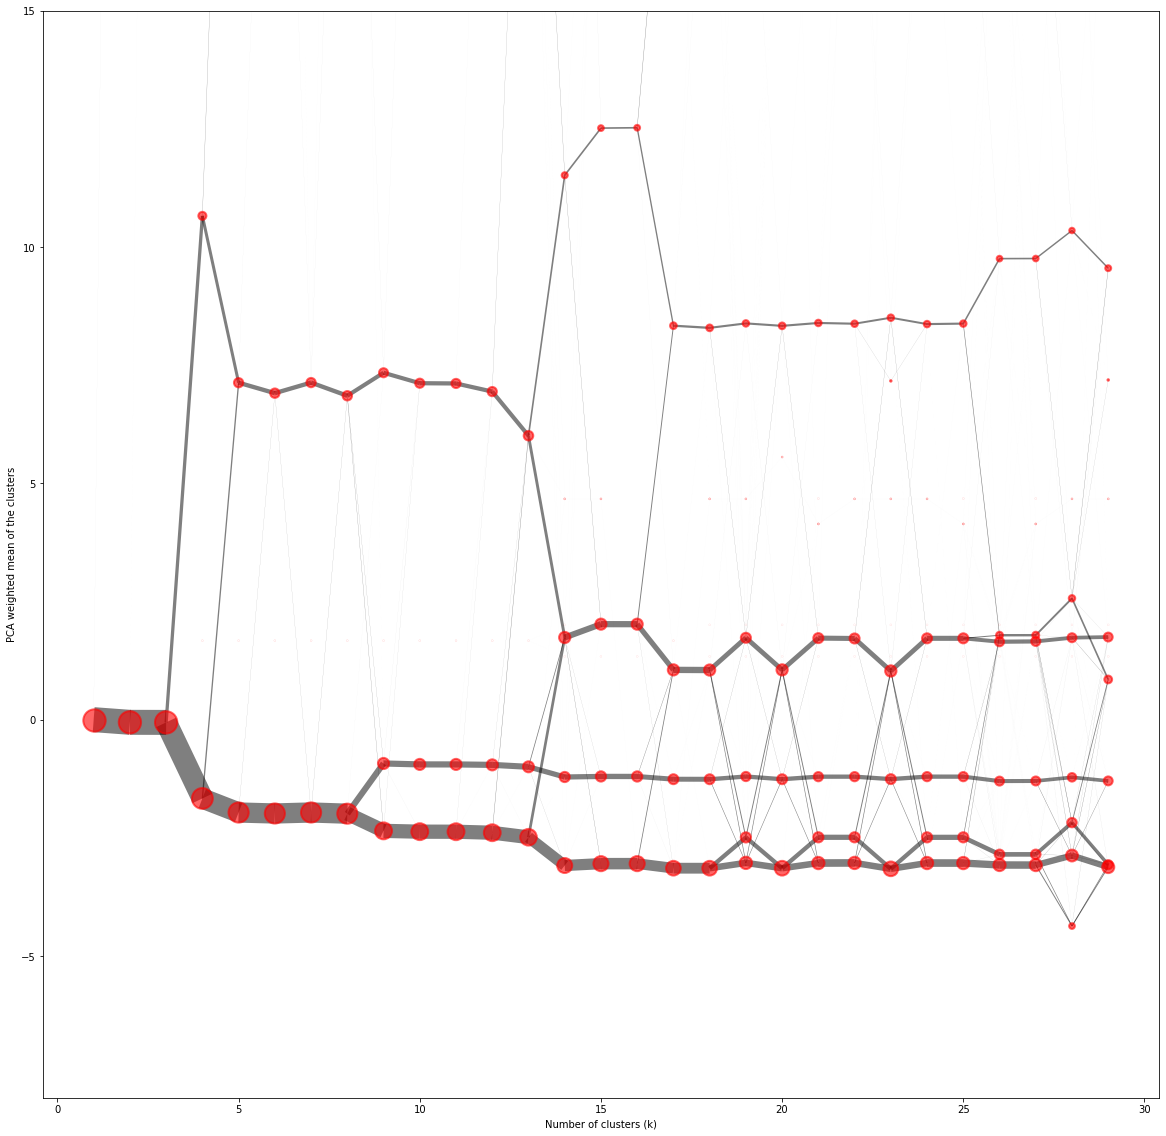

In [29]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-8, 15)

In [20]:
km = KMeans(n_clusters=17, n_init=10).fit(data)

In [9]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/tess.pq")
tess['clusters'] = km.labels_

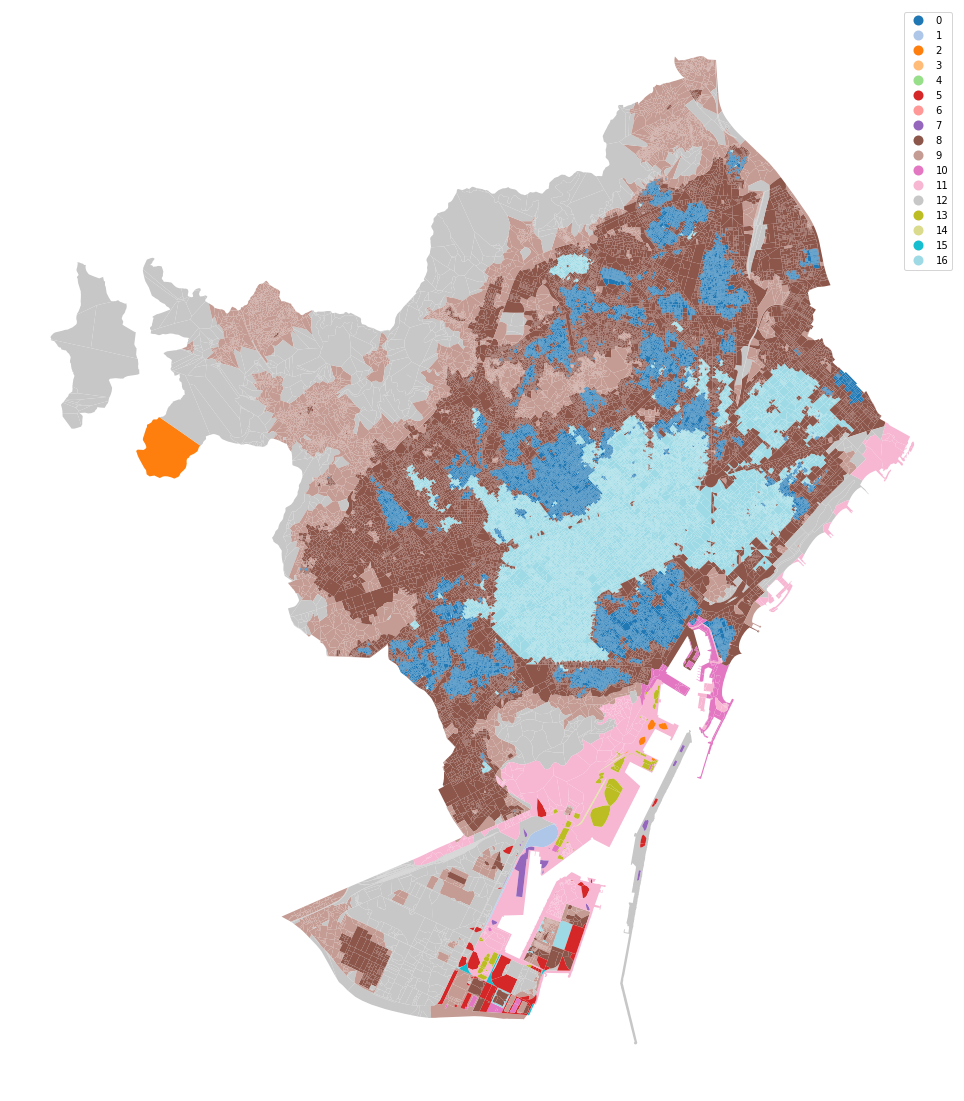

In [25]:
ax = tess.plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

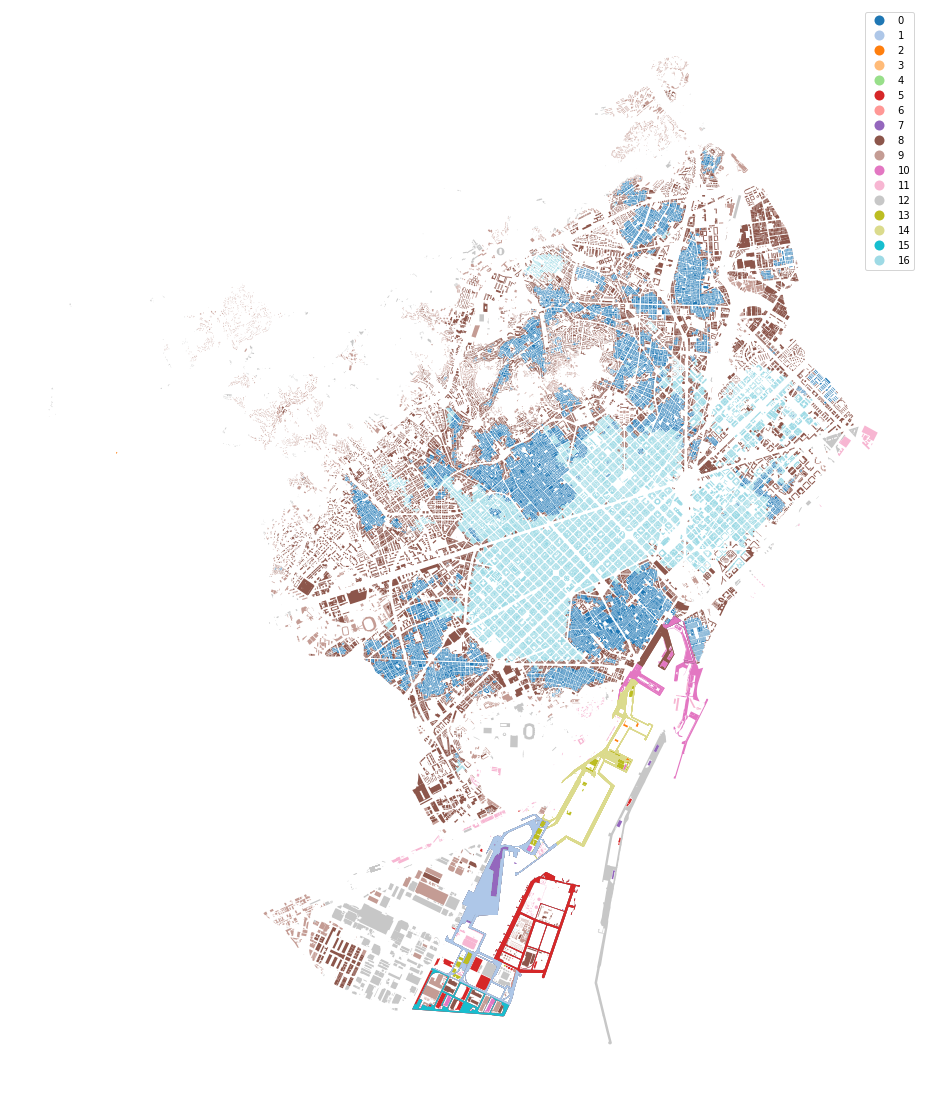

In [27]:
ax = tess.set_geometry('buildings').plot('clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [31]:
function = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/func_data.pq")

In [32]:
function.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'numberOfDwellings',
       'beginning', 'currentUse', 'age', 'FAMILIA', 'NUM_PARKINGS',
       'NUM_ALTRES', 'HABITANTS', 'heritage_area', 'nodeID', 'heritage',
       'restaurants', 'pois', 'culture', 'parks', 'trees', 'ndvi_min',
       'ndvi_max', 'ndvi_mean', 'ndvi_median'],
      dtype='object')

In [34]:
function_data = function[['tID', 'numberOfDwellings', 'currentUse', 'age', 'FAMILIA', 'NUM_PARKINGS', 'NUM_ALTRES', 'HABITANTS', 'heritage_area',
                               'heritage','restaurants', 'pois', 'culture', 'parks', 'trees', 'ndvi_min','ndvi_max', 'ndvi_mean']].set_index('tID')

In [35]:
function_data.head()

numberOfDwellings     currentUse   age     FAMILIA  NUM_PARKINGS  \
tID                                                                     
0                 14.0  1_residential  65.0  Casc Antic      0.118285   
1                 14.0  1_residential  70.0  Casc Antic      0.172536   
2                  1.0  1_residential  84.0  Casc Antic      0.087874   
3                 10.0  1_residential  15.0  Casc Antic      0.084238   
4                  1.0  1_residential  70.0  Casc Antic      0.087551   

     NUM_ALTRES  HABITANTS  heritage_area  heritage  restaurants  pois  \
tID                                                                      
0     20.693664  16.309376           True      3818         1281  1956   
1     30.357385  23.770880           True      3564         1179  1796   
2     15.460904  12.283816           True      3818         1281  1956   
3     14.825760  11.730704          False      3564         1179  1796   
4     15.457345  12.244764          False      3054          966  1450   

     culture  parks  trees  ndvi_min  ndvi_max  ndvi_mean  
tID                                                        
0        414     14      2     -0.13      0.58   0.033225  
1        414     14      4     -0.18      0.63   0.056501  
2        414     14      2     -0.17      0.65   0.080513  
3        414     14      2     -0.09      0.62   0.080907  
4        346      2      2     -0.10      0.39   0.038485

In [43]:
currentUse = pd.get_dummies(function_data.currentUse)
FAMILIA = pd.get_dummies(function_data.FAMILIA)
heritage_area = function_data.heritage_area.astype(int)

In [65]:
scaler = preprocessing.StandardScaler()  # may not be optimal - DISCUSS
f_data = scaler.fit_transform(function_data.drop(columns=["currentUse", "FAMILIA", "heritage_area"]).fillna(0))  # may not be optimal - DISCUSS

In [66]:
f_data.shape

(82375, 14)

In [67]:
f_data = np.hstack([f_data, currentUse.values, FAMILIA.values, np.array([heritage_area.values]).T])

In [68]:
f_data.shape

(82375, 42)

In [69]:
cg = Clustergram(range(1, 30), backend='cuML', n_init=10)
cg.fit(f_data)

PCA computed in 0.2072603702545166 seconds.
K=1 fitted in 0.4763455390930176 seconds.
K=2 fitted in 0.38858985900878906 seconds.
K=3 fitted in 2.9316182136535645 seconds.
K=4 fitted in 3.0791382789611816 seconds.
K=5 fitted in 3.118962049484253 seconds.
K=6 fitted in 2.7227261066436768 seconds.
K=7 fitted in 4.686907529830933 seconds.
K=8 fitted in 4.609544038772583 seconds.
K=9 fitted in 3.775115966796875 seconds.
K=10 fitted in 4.180140733718872 seconds.
K=11 fitted in 4.033673524856567 seconds.
K=12 fitted in 4.276897668838501 seconds.
K=13 fitted in 4.377471685409546 seconds.
K=14 fitted in 5.160050392150879 seconds.
K=15 fitted in 4.974894762039185 seconds.
K=16 fitted in 4.269580125808716 seconds.
K=17 fitted in 4.850391626358032 seconds.
K=18 fitted in 6.962002992630005 seconds.
K=19 fitted in 7.024827003479004 seconds.
K=20 fitted in 7.508535385131836 seconds.
K=21 fitted in 8.446369171142578 seconds.
K=22 fitted in 6.67735481262207 seconds.
K=23 fitted in 6.0251688957214355 se

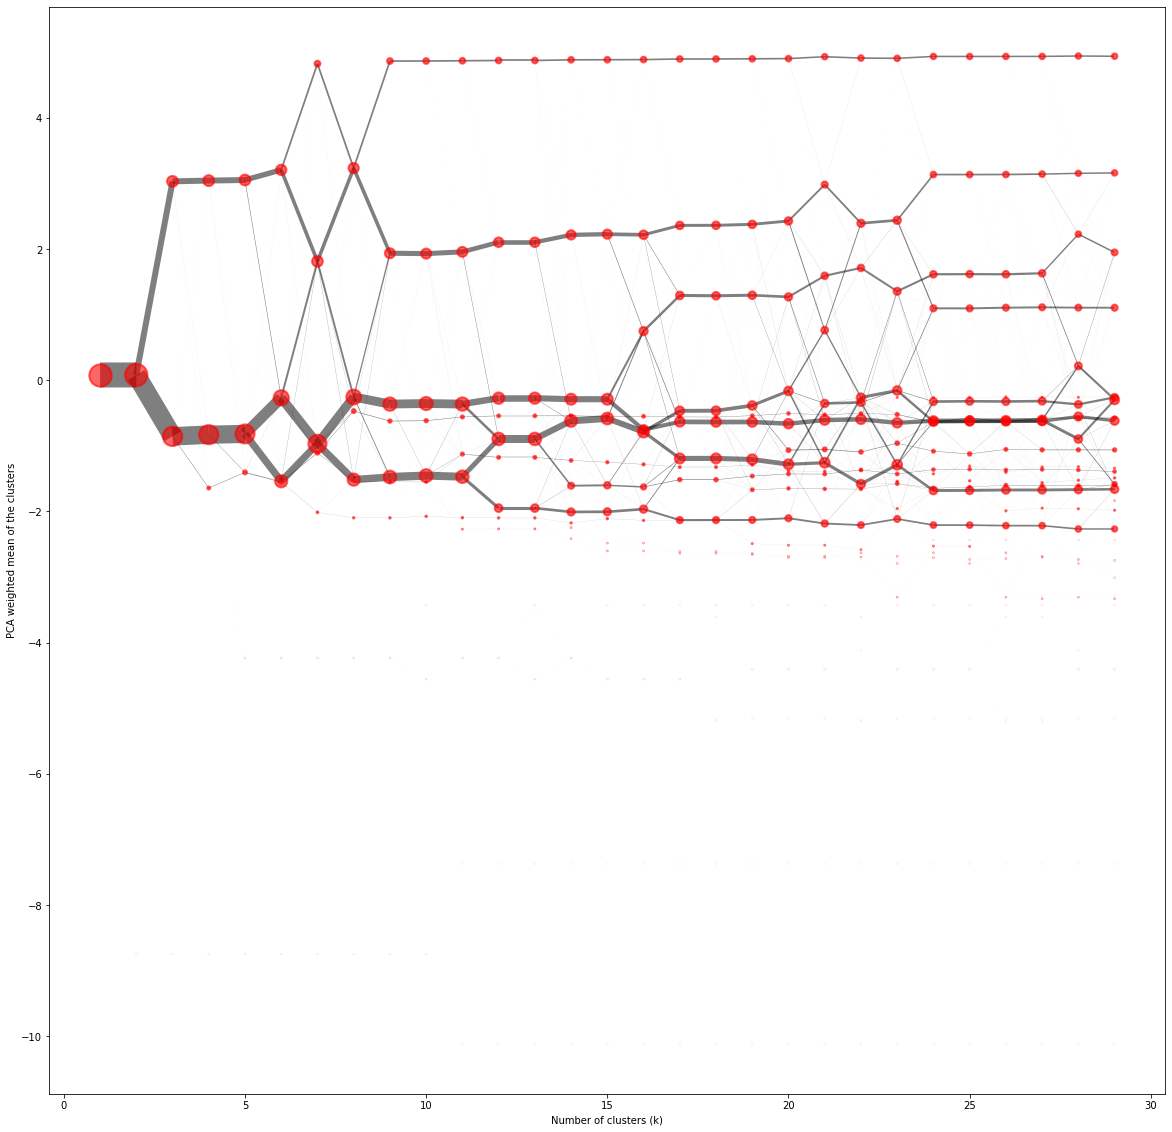

In [70]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

In [71]:
km = KMeans(n_clusters=12, n_init=10).fit(f_data)

In [72]:
tess['f_clusters'] = km.labels_

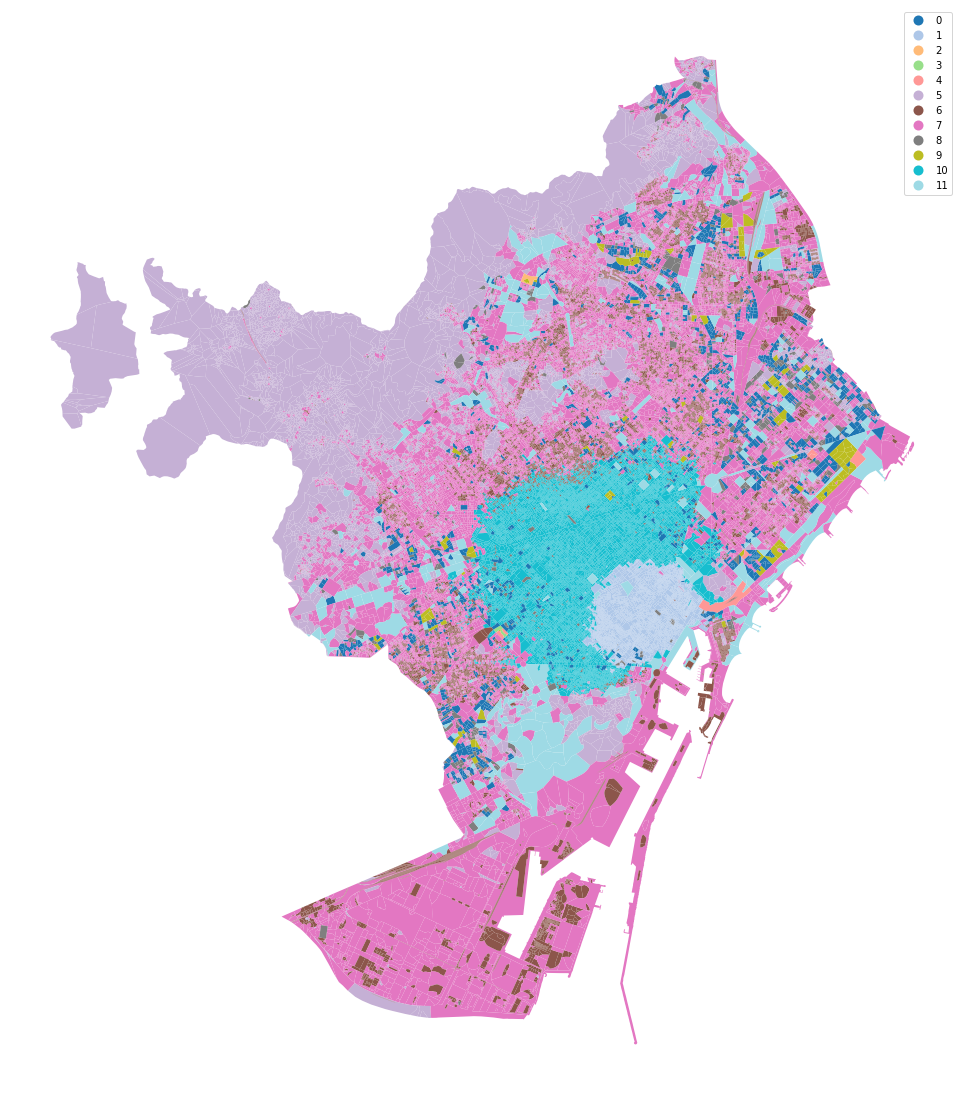

In [73]:
ax = tess.plot('f_clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

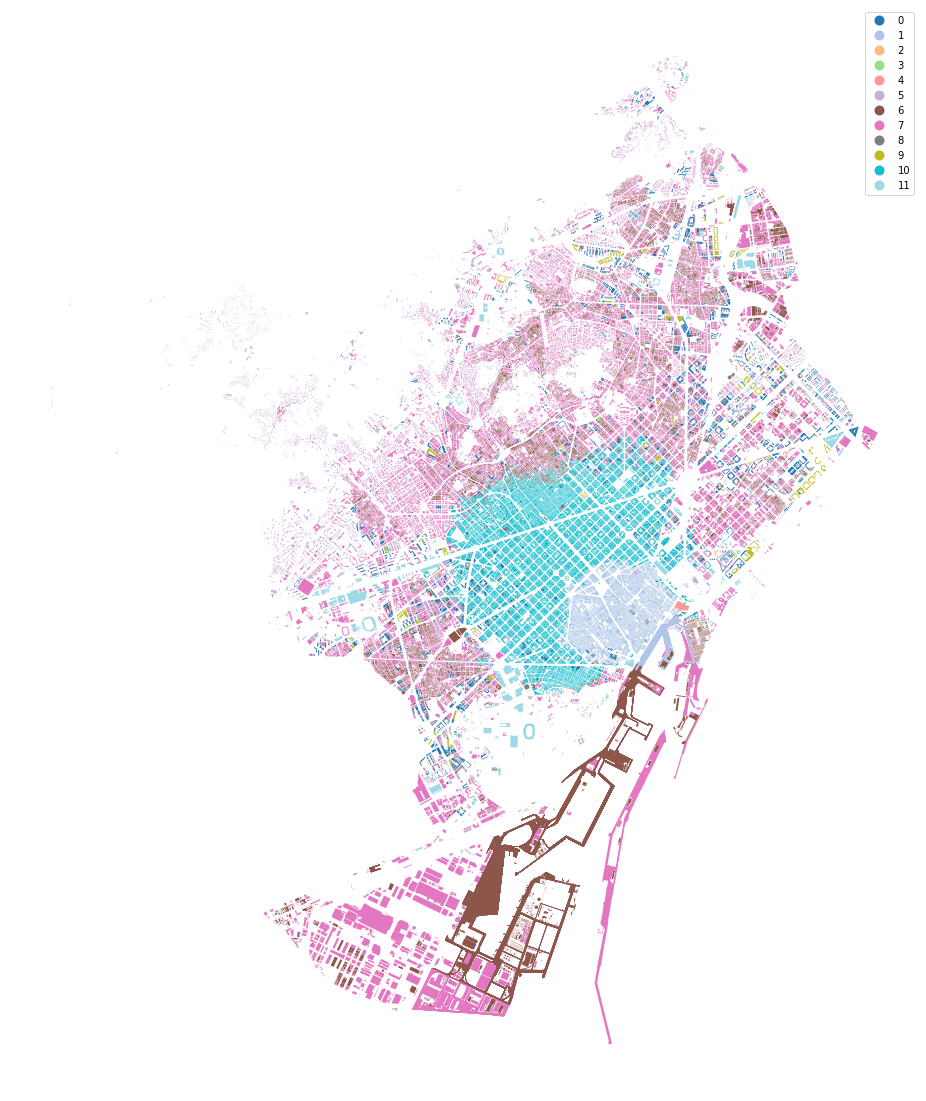

In [74]:
ax = tess.set_geometry('buildings').plot('f_clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [78]:
ss_data = np.hstack([data, f_data])

In [79]:
cg = Clustergram(range(1, 30), backend='cuML', n_init=10)
cg.fit(ss_data)

PCA computed in 0.24122381210327148 seconds.
K=1 fitted in 1.5496108531951904 seconds.
K=2 fitted in 1.6338021755218506 seconds.
K=3 fitted in 2.2362725734710693 seconds.
K=4 fitted in 3.476572036743164 seconds.
K=5 fitted in 3.6430208683013916 seconds.
K=6 fitted in 4.696532726287842 seconds.
K=7 fitted in 4.867143869400024 seconds.
K=8 fitted in 5.199143648147583 seconds.
K=9 fitted in 4.616255283355713 seconds.
K=10 fitted in 5.522911310195923 seconds.
K=11 fitted in 5.762475967407227 seconds.
K=12 fitted in 6.687705755233765 seconds.
K=13 fitted in 7.4262049198150635 seconds.
K=14 fitted in 8.758474111557007 seconds.
K=15 fitted in 7.261713027954102 seconds.
K=16 fitted in 9.981119155883789 seconds.
K=17 fitted in 9.023969173431396 seconds.
K=18 fitted in 10.409034013748169 seconds.
K=19 fitted in 11.04067611694336 seconds.
K=20 fitted in 9.84326958656311 seconds.
K=21 fitted in 9.966191530227661 seconds.
K=22 fitted in 12.000033378601074 seconds.
K=23 fitted in 11.336894035339355 

(-8.0, 15.0)

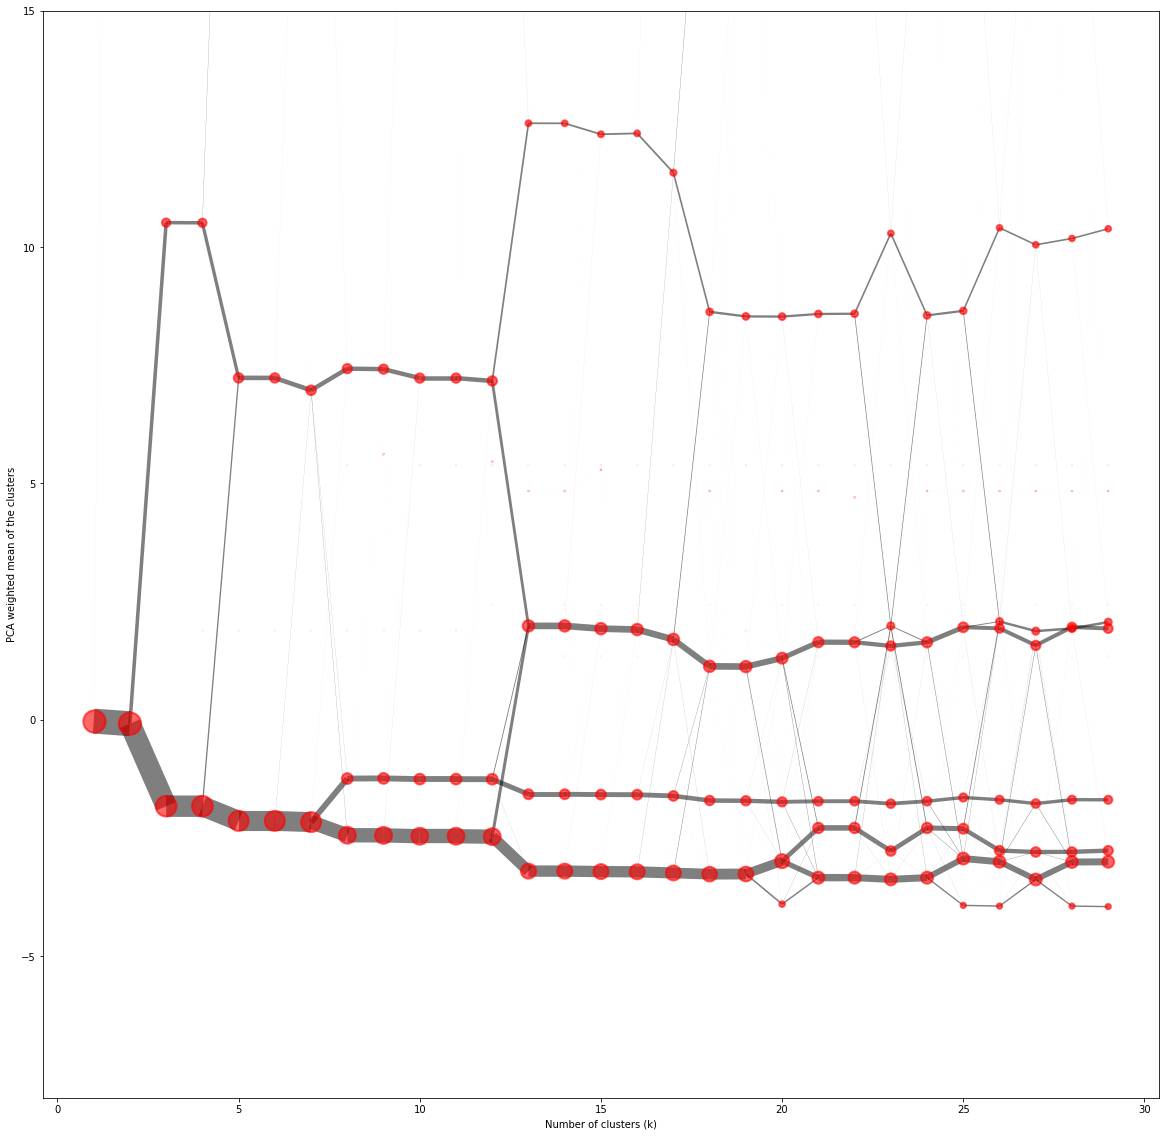

In [87]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})
ax.set_ylim(-8, 15)

In [81]:
km = KMeans(n_clusters=18, n_init=10).fit(ss_data)

In [82]:
tess['ss_clusters'] = km.labels_

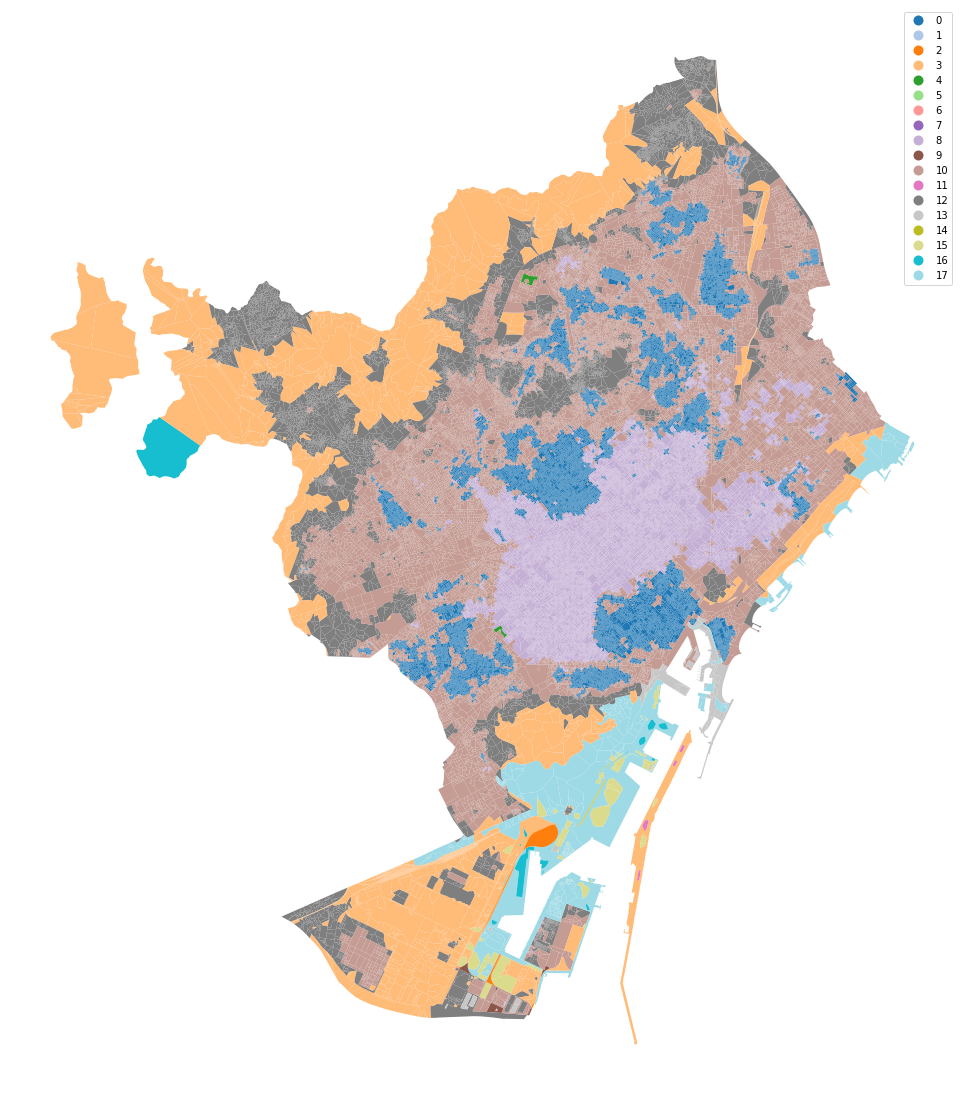

In [83]:
ax = tess.plot('ss_clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

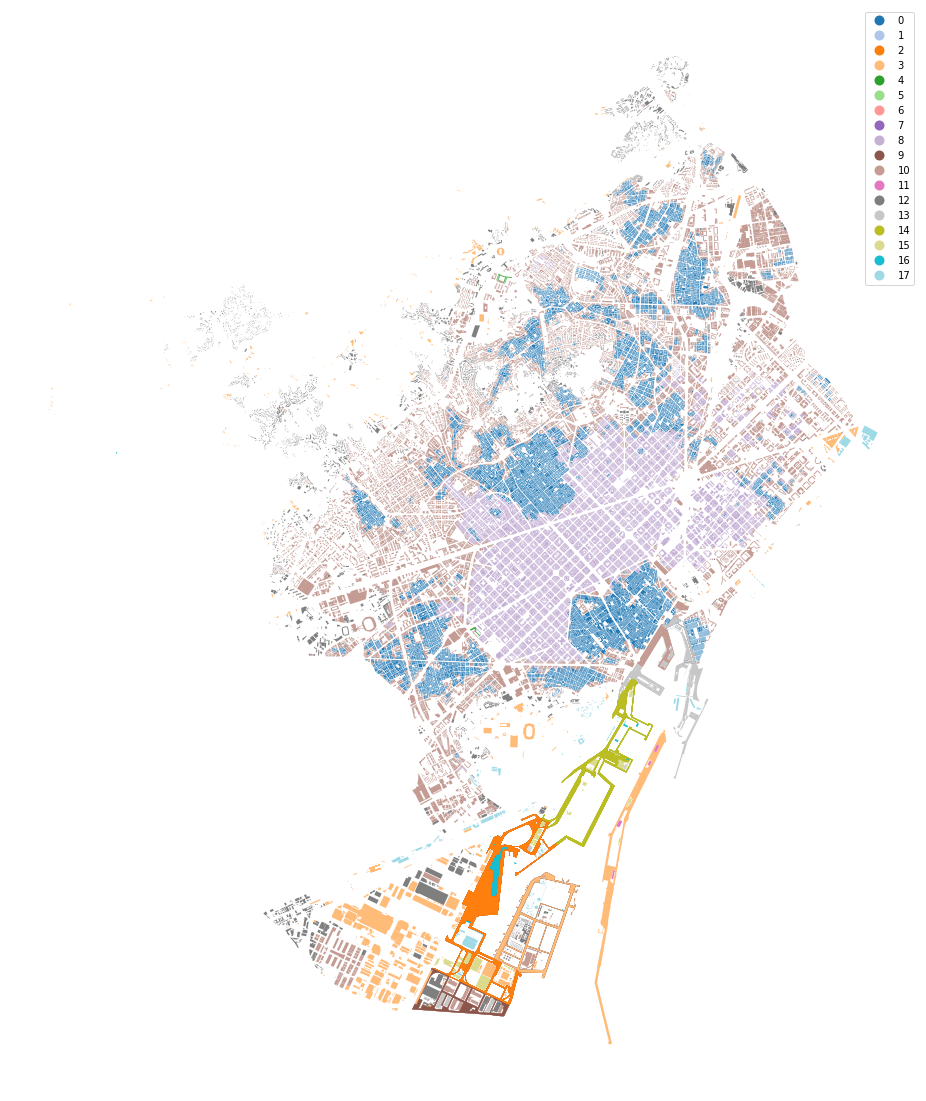

In [84]:
ax = tess.set_geometry('buildings').plot('ss_clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [88]:
tess.columns

Index(['uID', 'tessellation', 'eID', 'buildings', 'tID', 'stcOri', 'stbOri',
       'stbCeA', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'sicCAR', 'mtbAli',
       'mtbNDi', 'mtcWNe', 'mdcAre', 'ltbIBD', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stcSAl', 'ltcWRE', 'edgeID_keys2', 'edgeID_values2',
       'nodeID', 'clusters', 'f_clusters', 'ss_clusters'],
      dtype='object')

In [89]:
tess[['tID', 'clusters', 'f_clusters', 'ss_clusters']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/cluster_labels.pq")

### GMM

In [5]:
cg = Clustergram(range(5, 20), method='gmm')
cg.fit(data)

PCA computed in 0.34211039543151855 seconds.
K=5 fitted in 59.27226257324219 seconds.
K=6 fitted in 89.72969174385071 seconds.
K=7 fitted in 100.28997087478638 seconds.
K=8 fitted in 86.6867823600769 seconds.
K=9 fitted in 85.26125502586365 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=10 fitted in 230.1960895061493 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=11 fitted in 256.1048228740692 seconds.
K=12 fitted in 263.9638845920563 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=13 fitted in 308.8446342945099 seconds.
K=14 fitted in 170.63910794258118 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=15 fitted in 354.8348400592804 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=16 fitted in 394.1066143512726 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=17 fitted in 409.36448407173157 seconds.


/opt/conda/envs/rapids/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


K=18 fitted in 437.87996435165405 seconds.
K=19 fitted in 378.5892469882965 seconds.


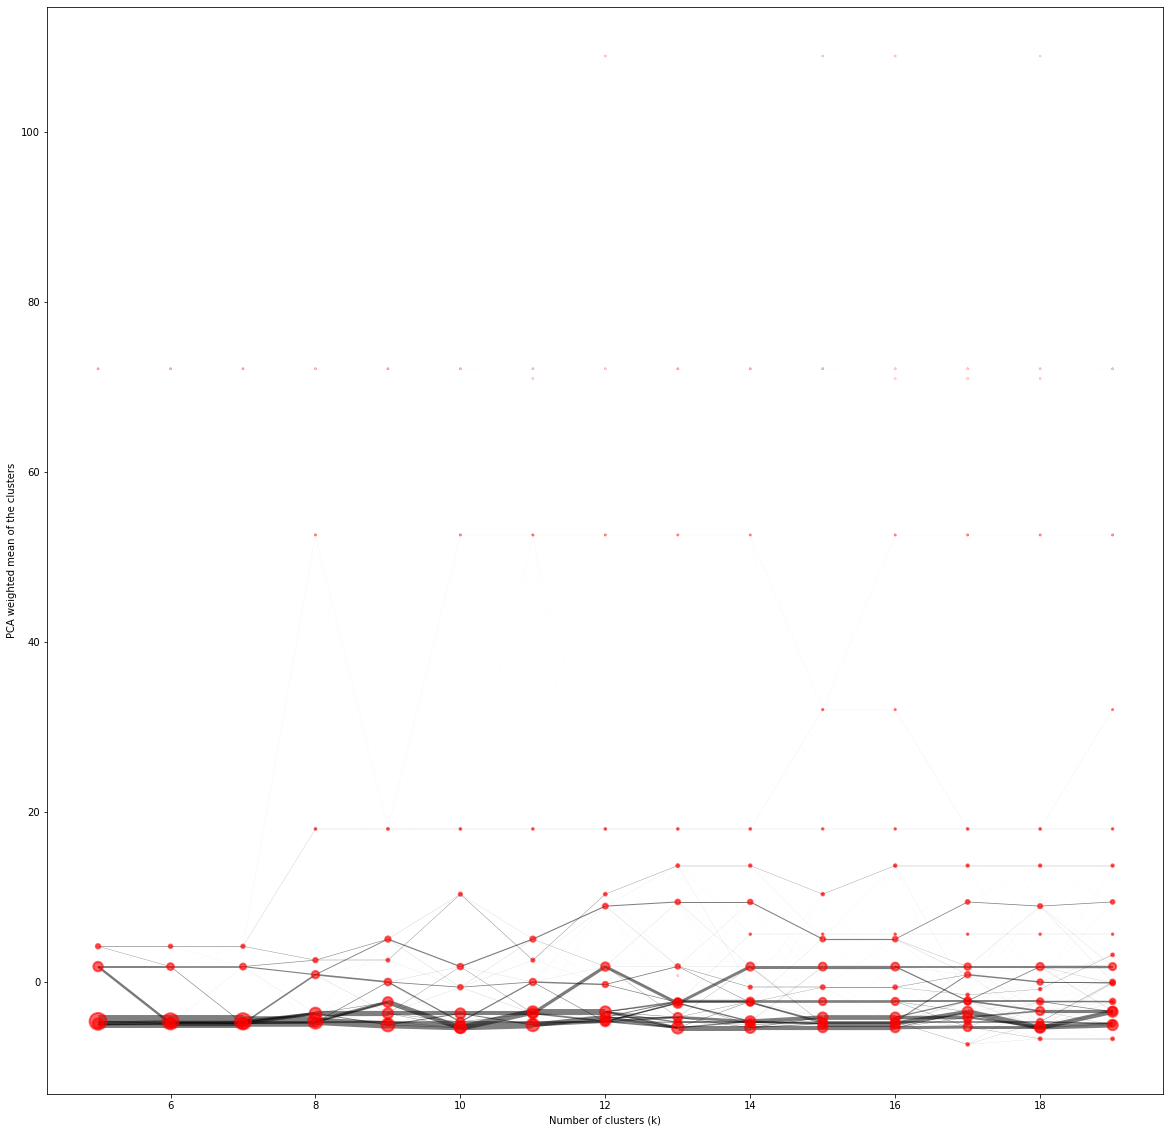

In [6]:
ax = cg.plot(figsize=(20, 20), linewidth=0.5, cluster_style={"edgecolor": "r", "alpha":.6}, size=1,
       line_style={"alpha":.5})

In [7]:
from sklearn.mixture import GaussianMixture

In [8]:
n = 17

gmm = GaussianMixture(n_components=n, covariance_type="full", max_iter=200, n_init=5, verbose=1)
fitted = gmm.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
  Iteration 100
  Iteration 110
  Iteration 120
  Iteration 130
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
Initialization converged: True


NameError: name 'tess' is not defined

In [10]:
tess['gmm_clusters'] = gmm.predict(data)

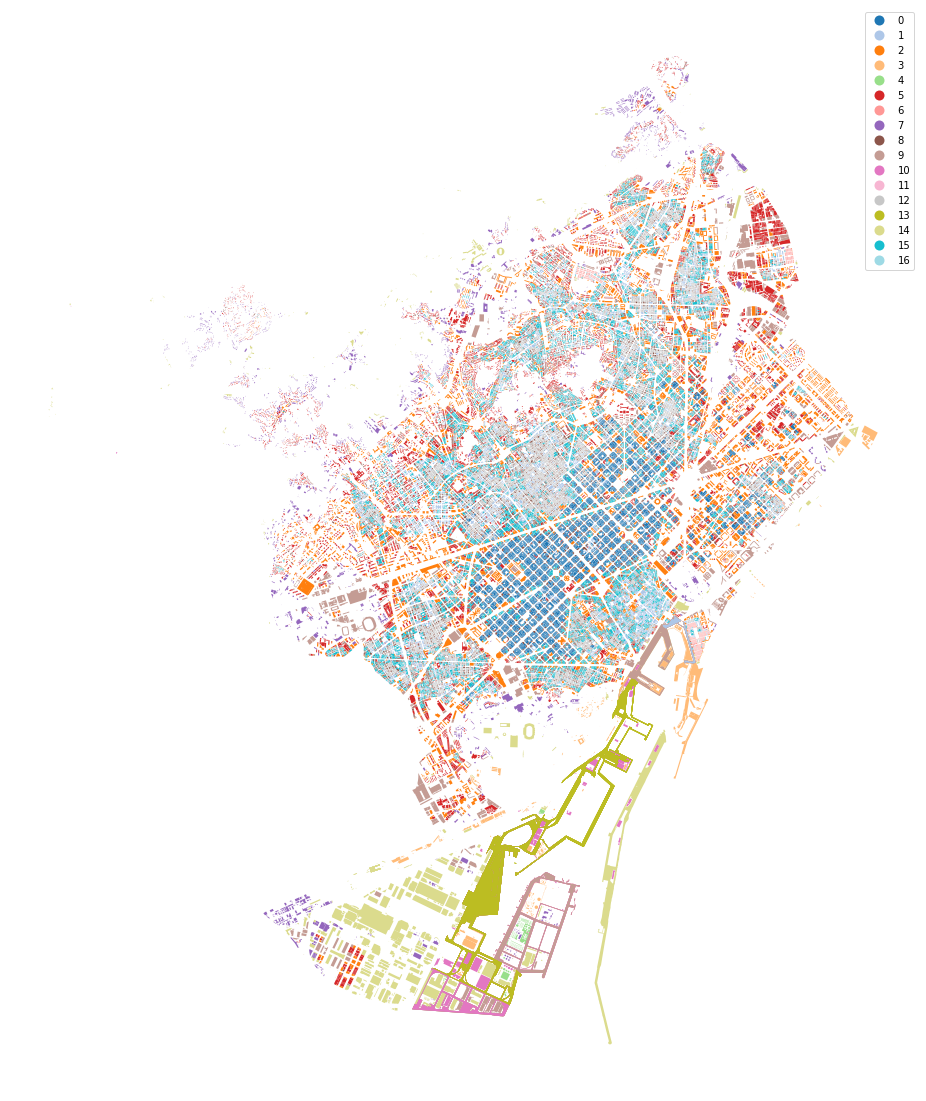

In [11]:
ax = tess.set_geometry('buildings').plot('gmm_clusters', categorical=True, legend=True, figsize=(20, 20), cmap='tab20')
ax.set_axis_off()

In [12]:
tess[['tID', 'gmm_clusters']].to_parquet("../../urbangrammar_samba/sp_sig_concept/barcelona/gmm_cluster_labels.pq")